In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import ttest_ind
from datetime import datetime, timedelta
import requests
import xml.etree.ElementTree as ET
import random

In [133]:
sales_df=pd.read_csv('sales_raw.csv')
discounts_df=pd.read_csv('discounts_raw.csv')

#### Посмотрим на данные

In [3]:
sales_df.head()

,date,item_id,qnty
0,2017-01-01,100001,7.0
1,2017-01-01,100003,2.0
2,2017-01-01,100006,13.0
3,2017-01-01,100010,5.0
4,2017-01-01,100035,53.0


In [4]:
discounts_df.head()

,item_id,promo_typeCode,sale_price_before_promo,sale_price_time_promo,date_start,date_end
0,100551,5.0,159.9,139.9,2023-03-02,2023-03-15
1,100553,5.0,159.9,139.9,2023-03-02,2023-03-15
2,100554,5.0,159.9,139.9,2023-03-02,2023-03-15
3,100558,5.0,159.9,139.9,2023-03-02,2023-03-15
4,100530,2.0,36.9,24.6,2021-09-09,2021-09-22


In [5]:
print("Информация по sales_df:")
print(sales_df.info())
print("\nИнформация по discounts_df:")
print(discounts_df.info())

Информация по sales_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147143 entries, 0 to 147142
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   date     147143 non-null  object 
 1   item_id  147143 non-null  int64  
 2   qnty     147143 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.4+ MB
None

Информация по discounts_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2081 entries, 0 to 2080
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   item_id                  2081 non-null   int64  
 1   promo_typeCode           2041 non-null   float64
 2   sale_price_before_promo  2081 non-null   float64
 3   sale_price_time_promo    2081 non-null   float64
 4   date_start               2081 non-null   object 
 5   date_end                 2081 non-null   object 
dtypes: float64(3), int64(1), object(

In [6]:
# Проверка на пропуски
print("Проверка на пропуски в sales_df:")
print(sales_df.isnull().sum())
print("\nПроверка на пропуски в discounts_df:")
print(discounts_df.isnull().sum())

Проверка на пропуски в sales_df:
date       0
item_id    0
qnty       0
dtype: int64

Проверка на пропуски в discounts_df:
item_id                     0
promo_typeCode             40
sale_price_before_promo     0
sale_price_time_promo       0
date_start                  0
date_end                    0
dtype: int64


Задача имеет временной ряд,необходимо его проанализировать

In [134]:
# Создание столбца 'date' из sales_df как datetime
sales_df['date'] = pd.to_datetime(sales_df['date'])

# Создание столбца 'date_start' и 'date_end' из discounts_df как datetime
discounts_df['date_start'] = pd.to_datetime(discounts_df['date_start'])
discounts_df['date_end'] = pd.to_datetime(discounts_df['date_end'])

In [8]:
# Поиск минимальной и максимальной даты в sales_df
min_date_sales = sales_df['date'].min()
max_date_sales = sales_df['date'].max()
print(f"\nМинимальная дата в sales_df: {min_date_sales}")
print(f"Максимальная дата в sales_df: {max_date_sales}")

# Поиск минимальной и максимальной даты в discounts_df
min_date_discounts = discounts_df['date_start'].min()
max_date_discounts = discounts_df['date_end'].max()
print(f"\nМинимальная дата в discounts_df: {min_date_discounts}")
print(f"Максимальная дата в discounts_df: {max_date_discounts}")


Минимальная дата в sales_df: 2017-01-01 00:00:00
Максимальная дата в sales_df: 2023-12-31 00:00:00

Минимальная дата в discounts_df: 2020-01-02 00:00:00
Максимальная дата в discounts_df: 2024-02-14 00:00:00


#### Соединение
Нам необходимо соединить данные из sales_df и discounts_df. Сложность в том, что для каждой продажи item_id могут быть разные акции или отсутствовать вовсе. Если соединять напрямую, мы получим много дубликатов продаж, у которых будут отличаться признаки даты скидки, даже если они никак не относятся к этой продаже.

В данных о скидках есть начальная (date_start) и конечная (date_end) даты действия скидки. Чтобы учитывать влияние скидок на ежедневные продажи, нужно создать записи для каждого дня в этом диапазоне.

Для этого проведем:

1.Определение диапазона дат: Для каждой строки в данных о скидках мы определяем все даты между начальной и конечной датой скидки.
2.Создание новых записей: Для каждого дня в этом диапазоне создаем отдельную запись, включающую информацию о товаре, типе акции, ценах до и во время акции и самой дате.

Таким образом, получаем датафрейм, в котором каждая запись представляет один день действия скидки для определенного товара.

Затем мы соединим его с датафреймом продаж и получим только те записи, которые указывают на отдельную продажу со скидкой или без, без дублирования записей.

In [424]:
# Создадим пустой DataFrame для хранения расширенных данных
expanded_discounts = []

# Заполним expanded_discounts строками с каждым днем действия скидки
for _, row in discounts_df.iterrows():
    expanded_dates = pd.date_range(start=row['date_start'], end=row['date_end'], freq='D')
    for date in expanded_dates:
        expanded_discounts.append([
            row['item_id'],
            row['promo_typeCode'],  
            row['sale_price_before_promo'],
            row['sale_price_time_promo'],
            date,
            row['date_start'],
            row['date_end']
        ])

# Преобразуем в DataFrame
expanded_discounts_df = pd.DataFrame(expanded_discounts, columns=[
    'item_id', 'promo_typeCode', 'sale_price_before_promo', 'sale_price_time_promo', 'date', 'date_start', 'date_end'
])

# Объединяем sales_df и expanded_discounts_df по item_id и date
merged_df = pd.merge(sales_df, expanded_discounts_df, on=['item_id', 'date'], how='left')

# Вывод первых нескольких строк объединенного DataFrame
display(merged_df.head())

,date,item_id,qnty,promo_typeCode,sale_price_before_promo,sale_price_time_promo,date_start,date_end
0,2017-01-01,100001,7.0,NaN,NaN,NaN,NaT,NaT
1,2017-01-01,100003,2.0,NaN,NaN,NaN,NaT,NaT
2,2017-01-01,100006,13.0,NaN,NaN,NaN,NaT,NaT
3,2017-01-01,100010,5.0,NaN,NaN,NaN,NaT,NaT
4,2017-01-01,100035,53.0,NaN,NaN,NaN,NaT,NaT


In [425]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147287 entries, 0 to 147286
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   date                     147287 non-null  datetime64[ns]
 1   item_id                  147287 non-null  int64         
 2   qnty                     147287 non-null  float64       
 3   promo_typeCode           20094 non-null   float64       
 4   sale_price_before_promo  20581 non-null   float64       
 5   sale_price_time_promo    20581 non-null   float64       
 6   date_start               20581 non-null   datetime64[ns]
 7   date_end                 20581 non-null   datetime64[ns]
dtypes: datetime64[ns](3), float64(4), int64(1)
memory usage: 9.0 MB


Видим, что количество строк в merged_df незначительно больше, чем в sales_df. Возможно, это связано с образовавшимися дубликатами или дополнительными неизвестными строчками. Давайте проверим это.

In [12]:
min_date_merged_df = merged_df['date'].min()
max_date_merged_df = merged_df['date'].max()
print(f"\nМинимальная дата в merged_df: {min_date_merged_df}")
print(f"Максимальная дата в merged_df: {max_date_merged_df}")


Минимальная дата в merged_df: 2017-01-01 00:00:00
Максимальная дата в merged_df: 2023-12-31 00:00:00


In [13]:
# Найдем строки в merged_df, которых нет в sales_df
additional_rows = merged_df.merge(sales_df[['date', 'item_id']], on=['date', 'item_id'], how='left', indicator=True)
additional_rows = additional_rows[additional_rows['_merge'] == 'left_only']

# Выводим количество дополнительных строк и примеры
print(f"Количество строк в merged_df, которых нет в sales_df: {additional_rows.shape[0]}")
print("Примеры дополнительных строк:")
print(additional_rows.head())

Количество строк в merged_df, которых нет в sales_df: 0
Примеры дополнительных строк:
Empty DataFrame
Columns: [date, item_id, qnty, promo_typeCode, sale_price_before_promo, sale_price_time_promo, date_start, date_end, _merge]
Index: []


In [14]:
merged_df.duplicated().sum()

0

С этим все в порядке. Появилась гипотеза, что один и тот же товар мог быть продан в один день, но по разным акциям, отсюда и увеличение строк. Проверим это.

In [136]:
# Проверка на дубликаты, которые повторяют исключительно комбинацию столбцов item_id, date, qnty
duplicates = merged_df[merged_df.duplicated(subset=['item_id', 'date', 'qnty'], keep=False)]

# Вывод количества дубликатов и примеры дубликатов
print(f"Количество дубликатов: {duplicates.shape[0]}")
print("Примеры дубликатов:")
display(duplicates.head())

Количество дубликатов: 288
Примеры дубликатов:


,date,item_id,qnty,promo_typeCode,sale_price_before_promo,sale_price_time_promo,date_start,date_end
74379,2020-06-30,100257,11.0,10.0,53.9,29.9,2020-06-30,2020-07-06
74380,2020-06-30,100257,11.0,5.0,53.9,34.9,2020-06-25,2020-07-08
74381,2020-06-30,100259,9.0,10.0,53.9,29.9,2020-06-30,2020-07-06
74382,2020-06-30,100259,9.0,5.0,53.9,34.9,2020-06-25,2020-07-08
74426,2020-06-30,100469,44.0,10.0,53.9,37.9,2020-06-30,2020-07-06


Так и есть. Значит, никакой ошибки нет, и работаем с этим датафреймом дальше. Давайте посмотрим еще раз на него.

In [55]:
merged_df

,date,item_id,qnty,promo_typeCode,sale_price_before_promo,sale_price_time_promo,date_start,date_end
0,2017-01-01,100001,7.0,NaN,NaN,NaN,NaT,NaT
1,2017-01-01,100003,2.0,NaN,NaN,NaN,NaT,NaT
2,2017-01-01,100006,13.0,NaN,NaN,NaN,NaT,NaT
3,2017-01-01,100010,5.0,NaN,NaN,NaN,NaT,NaT
4,2017-01-01,100035,53.0,NaN,NaN,NaN,NaT,NaT
...,...,...,...,...,...,...,...,...
147282,2023-12-31,100614,5.0,NaN,NaN,NaN,NaT,NaT
147283,2023-12-31,100140,4.0,6.0,749.9,689.9,2023-12-19,2024-01-08
147284,2023-12-31,100650,11.0,5.0,109.9,79.9,2023-12-20,2024-01-10
147285,2023-12-31,100182,1.0,NaN,NaN,NaN,NaT,NaT


Добавим признак is_promo для визуализации продаж во время акции и без неё. Видим, что акции не всегда влияют на продажи.

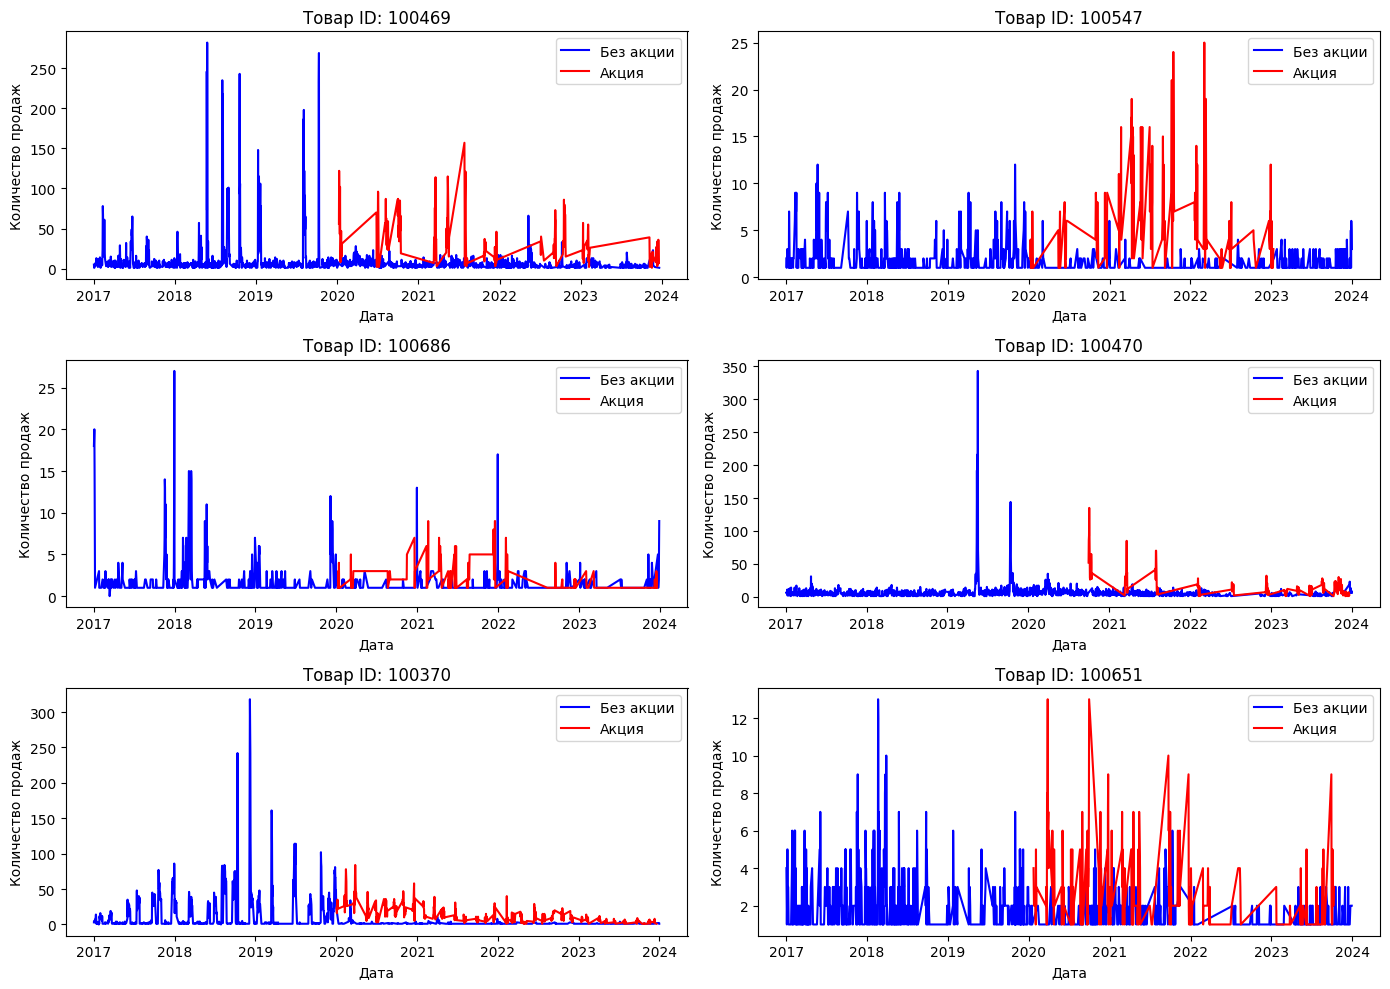

In [137]:
# Создание булевого столбца для периодов акций
merged_df['is_promo'] = merged_df.apply(lambda row: row['date_start'] <= row['date'] <= row['date_end'] if pd.notnull(row['date_start']) and pd.notnull(row['date_end']) else False, axis=1)

# Выбор шести случайных товаров
random_items = merged_df['item_id'].dropna().unique()
selected_items = np.random.choice(random_items, 6, replace=False)

# Построение графиков
plt.figure(figsize=(14, 10))

for i, item_id in enumerate(selected_items):
    plt.subplot(3, 2, i+1)
    item_data = merged_df[merged_df['item_id'] == item_id]
    
    sns.lineplot(data=item_data[item_data['is_promo'] == False], x='date', y='qnty', label='Без акции', color='blue')
    sns.lineplot(data=item_data[item_data['is_promo'] == True], x='date', y='qnty', label='Акция', color='red')
    
    plt.title(f'Товар ID: {item_id}')
    plt.xlabel('Дата')
    plt.ylabel('Количество продаж')
    plt.legend()

plt.tight_layout()
plt.show()

Проведем тестирование, чтобы выяснить, влияют ли скидочные акции на продажи.

In [18]:
# Разделяем данные на дни с акциями и без акций
promo_sales = merged_df[merged_df['is_promo']]['qnty']
non_promo_sales = merged_df[~merged_df['is_promo']]['qnty']

# Проведение t-теста для независимых выборок
t_stat, p_value = ttest_ind(promo_sales, non_promo_sales, equal_var=False)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Интерпретация результатов
if p_value < 0.05:
    print("Статистически значимая разница в продажах между днями с акцией и без.")
else:
    print("Нет статистически значимой разницы в продажах между днями с акцией и без.")

T-statistic: -0.5797725137265374
P-value: 0.5620700913244254
Нет статистически значимой разницы в продажах между днями с акцией и без.


Как видим, скидочные акции не оказывают значительного влияния на продажи. Однако, по условию задачи, нам необходимо учитывать этот фактор. Поэтому этот тест был проведен для интереса.

In [19]:
print("Проверка на пропуски в sales_df:")
print(merged_df.isnull().sum())

Проверка на пропуски в sales_df:
date                            0
item_id                         0
qnty                            0
promo_typeCode             127193
sale_price_before_promo    126706
sale_price_time_promo      126706
date_start                 126706
date_end                   126706
is_promo                        0
dtype: int64


#### Feature engineering
Видим большое количество пропусков. С такими данными будет сложно работать.

Для оформления данных я предлагаю несколько идей:

1. Заменить promo_typeCode NaN на promo_typeCode со значением 0. Это добавит отдельное значение кода акции, когда её как бы нет. Это избавит нас от создания дополнительного столбца is_promo, показывающего, была ли акция в этот день или нет.

2. sale_price_before_promo и sale_price_time_promo преобразовать в столбцы, показывающие, насколько изменилась цена в абсолютных значениях и в процентах. Это отразит изменение цены, в том числе очень высокое, и позволит убрать пропуски, так как, если акции не было, то и изменения цены тоже не было, и там, где NaN, можно просто поставить 0.

3. По условию нужно также учитывать день недели. Добавим соответствующий столбец.

In [138]:
# Добавление признаков изменения цены в единицах и процентах
merged_df['price_change_units'] = merged_df['sale_price_before_promo'] - merged_df['sale_price_time_promo']
merged_df['price_change_percent'] = (merged_df['price_change_units'] / merged_df['sale_price_before_promo']) * 100

# Добавление признака дня недели
merged_df['day_of_week'] = merged_df['date'].dt.dayofweek

merged_df

,date,item_id,qnty,promo_typeCode,sale_price_before_promo,sale_price_time_promo,date_start,date_end,is_promo,price_change_units,price_change_percent,day_of_week
0,2017-01-01,100001,7.0,NaN,NaN,NaN,NaT,NaT,False,NaN,NaN,6
1,2017-01-01,100003,2.0,NaN,NaN,NaN,NaT,NaT,False,NaN,NaN,6
2,2017-01-01,100006,13.0,NaN,NaN,NaN,NaT,NaT,False,NaN,NaN,6
3,2017-01-01,100010,5.0,NaN,NaN,NaN,NaT,NaT,False,NaN,NaN,6
4,2017-01-01,100035,53.0,NaN,NaN,NaN,NaT,NaT,False,NaN,NaN,6
...,...,...,...,...,...,...,...,...,...,...,...,...
147282,2023-12-31,100614,5.0,NaN,NaN,NaN,NaT,NaT,False,NaN,NaN,6
147283,2023-12-31,100140,4.0,6.0,749.9,689.9,2023-12-19,2024-01-08,True,60.0,8.001067,6
147284,2023-12-31,100650,11.0,5.0,109.9,79.9,2023-12-20,2024-01-10,True,30.0,27.297543,6
147285,2023-12-31,100182,1.0,NaN,NaN,NaN,NaT,NaT,False,NaN,NaN,6


Теперь уберем более ненужные столбцы date_start, date_end, sale_price_before_promo, sale_price_time_promo и заполним пропуски.

In [139]:
merged_df=merged_df.drop(['date_start','date_end','sale_price_before_promo','sale_price_time_promo','is_promo'],axis=1)
# Заполнение пропусков в promo_typeCode нулями
merged_df.fillna(0, inplace=True)
merged_df.head()

,date,item_id,qnty,promo_typeCode,price_change_units,price_change_percent,day_of_week
0,2017-01-01,100001,7.0,0.0,0.0,0.0,6
1,2017-01-01,100003,2.0,0.0,0.0,0.0,6
2,2017-01-01,100006,13.0,0.0,0.0,0.0,6
3,2017-01-01,100010,5.0,0.0,0.0,0.0,6
4,2017-01-01,100035,53.0,0.0,0.0,0.0,6


In [59]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147287 entries, 0 to 147286
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   date                  147287 non-null  datetime64[ns]
 1   item_id               147287 non-null  int64         
 2   qnty                  147287 non-null  float64       
 3   promo_typeCode        147287 non-null  float64       
 4   price_change_units    147287 non-null  float64       
 5   price_change_percent  147287 non-null  float64       
 6   day_of_week           147287 non-null  int32         
dtypes: datetime64[ns](1), float64(4), int32(1), int64(1)
memory usage: 7.3 MB


Возможно, в датасете есть значения с отрицательными значениями продаж. Проверим это.

In [60]:
# Проверка наличия отрицательных значений в qnty
negative_values = merged_df[merged_df['qnty'] < 0]
num_negative_values = len(negative_values)

print(f'Number of negative values in qnty: {num_negative_values}')

Number of negative values in qnty: 14


Хотя это и возможно, например, возвраты или какие-то другие особенности конкретно этого случая продаж, но я предполагаю, что это ошибка ввода данных. Поэтому просто заменю отрицательные значения на положительные.

In [140]:
# Замена отрицательных значений в qnty на абсолютные значения
merged_df['qnty'] = merged_df['qnty'].abs()

# Проверка на наличие отрицательных значений после замены
negative_values_after_replacement = merged_df[merged_df['qnty'] < 0]
num_negative_values_after_replacement = len(negative_values_after_replacement)

print(f'Number of negative values in qnty after replacement: {num_negative_values_after_replacement}')

Number of negative values in qnty after replacement: 0


#### Baseline
В качестве baseline  модели я выбираю RandomForestRegressor. Он позволит учитывать категориальные признаки, как и нужно по условию задачи.

Для тренировочной и тестовой выборки следует взять разделение по дате, так как мы делаем прогнозирование продаж.

Для начала выберем дату, по которой разделим данные на тренировочную и тестовую выборку.

In [62]:
# Сортируем данные по дате
merged_df_date = merged_df.sort_values(by='date')

# Определяем количество строк, соответствующее 80% данных
split_index = int(0.8 * len(merged_df_date))

# Находим дату, на которой заканчиваются эти 80% данных
split_date = merged_df_date.iloc[split_index]['date']

# Разделение данных на обучающую и тестовую выборки по найденной дате
train_df_date = merged_df_date[merged_df_date['date'] < split_date]
test_df_date = merged_df_date[merged_df_date['date'] >= split_date]

# Проверяем, что все item_id из train_df_date присутствуют в test_df_date
train_item_ids = set(train_df_date['item_id'])
test_item_ids = set(test_df_date['item_id'])

missing_item_ids = train_item_ids - test_item_ids

if missing_item_ids:
    print(f"Этих item_id нет в тестовом наборе: {missing_item_ids}")
else:
    print(f"Все item_id представленны и в тренировочном и в тестовом наборе .")

# Выводим найденную дату
print(f"Выбранная дата: {split_date}")

Все item_id представленны и в тренировочном и в тестовом наборе .
Выбранная дата: 2022-08-12 00:00:00


In [63]:
merged_df_before = merged_df[merged_df['date'] <= '2022-08-12']
merged_df_after = merged_df[merged_df['date'] > '2022-08-12']
print(f"\nМинимальная дата в merged_df: {len(merged_df_before)}")
print(f"Максимальная дата в merged_df: {len(merged_df_after)}")


Минимальная дата в merged_df: 117893
Максимальная дата в merged_df: 29394


In [141]:
# Подготовка данных
# Определяем целевую переменную и признаки
target = 'qnty'
features = merged_df.drop(columns=[target, 'date']).columns


In [142]:
# Разделение данных на обучающую и тестовую выборки по дате
train_df = merged_df[merged_df['date'] < '2022-08-12']
test_df = merged_df[merged_df['date'] >= '2022-08-12']

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

In [111]:
# Создание и обучение модели RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Прогнозирование на тестовой выборке
y_pred = model.predict(X_test)

In [112]:
# Оценка качества модели
rmse = root_mean_squared_error(y_test, y_pred )
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error: {rmse}')
print(f'MAE: {mae}')
print(f'R2: {r2:.4f}')


Root Mean Squared Error: 14.098260263723814
MAE: 5.284061152824847
R2: 0.7968


Есть над чем работать.Хочу попробовать модели XGBoost, LightBM, CatBoost и оценку временных рядов с SariMax

### Эксперименты

#### XGBoost

In [113]:
# Преобразование категориальных признаков в числовые
X_train_xgb = pd.get_dummies(X_train, drop_first=True)
X_test_xgb  = pd.get_dummies(X_test, drop_first=True)

# Приведение тестовых данных в соответствие с обучающими
X_test_xgb = X_test_xgb.reindex(columns=X_train_xgb.columns, fill_value=0)

# Создание DMatrix для XGBoost
dtrain = xgb.DMatrix(X_train_xgb, label=y_train)
dtest = xgb.DMatrix(X_test_xgb, label=y_test)

# Параметры модели
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42
}

# Обучение модели
model = xgb.train(params, dtrain, num_boost_round=1000, evals=[(dtest, 'test')], early_stopping_rounds=50, verbose_eval=100)

# Предсказание на тестовом наборе данных
y_pred = model.predict(dtest)

# Оценка качества модели
rmse = root_mean_squared_error(y_test, y_pred )
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error: {rmse}')
print(f'MAE: {mae}')
print(f'R2: {r2:.4f}')

[0]	test-rmse:28.84269
[100]	test-rmse:13.82137
[200]	test-rmse:13.55752
[300]	test-rmse:13.42896
[400]	test-rmse:13.32052
[454]	test-rmse:13.32993
Root Mean Squared Error: 13.32600389239029
MAE: 5.134590506776678
R2: 0.8184


Уже чуть лучше

#### LightGBM

In [114]:
# Создание Dataset для LightGBM
dtrain = lgb.Dataset(X_train, label=y_train)
dtest = lgb.Dataset(X_test, label=y_test, reference=dtrain)

# Параметры модели
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'num_leaves': 31,
    'random_state': 42
}

# Обучение модели
model = lgb.train(params, dtrain, num_boost_round=1000, valid_sets=[dtest])

# Предсказание на тестовом наборе данных
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Оценка качества модели
rmse = root_mean_squared_error(y_test, y_pred )
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error: {rmse}')
print(f'MAE: {mae}')
print(f'R2: {r2:.4f}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 468
[LightGBM] [Info] Number of data points in the train set: 117829, number of used features: 5
[LightGBM] [Info] Start training from score 8.770899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

Чуть лучше

#### CatBoost

In [73]:
# Определение категориальных признаков
categorical_features = ['item_id', 'promo_typeCode', 'day_of_week']
# Числовые признаки
numeric_features = ['price_change_units', 'price_change_percent']

# Преобразование признаков в строки для правильной работы CatBoostRegressor
X_train_cgr = X_train.copy()
X_test_cgr = X_test.copy()

for col in ['item_id', 'promo_typeCode', 'day_of_week']:
    X_train_cgr[col] = X_train_cgr[col].astype(str)
    X_test_cgr[col] = X_test_cgr[col].astype(str)

# Создание пула данных для CatBoost
train_pool = Pool(X_train_cgr, y_train, cat_features=categorical_features)
test_pool = Pool(X_test_cgr, y_test, cat_features=categorical_features)

# Создание модели
model = CatBoostRegressor(
    iterations=3000,
    learning_rate=0.1,
    depth=10,
    loss_function='MAE',
    eval_metric='MAE',
    random_seed=42,
    l2_leaf_reg=3,
    bootstrap_type='Bernoulli',
    subsample=0.8,
    cat_features=categorical_features,
    one_hot_max_size=200,
    logging_level='Verbose',
    od_type='Iter',
    od_wait=500
)

# Обучение модели
model.fit(train_pool, eval_set=test_pool, verbose=100, early_stopping_rounds=500)

# Предсказание на тестовом наборе данных
y_pred = model.predict(test_pool)

# Оценка качества модели
rmse = root_mean_squared_error(y_test, y_pred )
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error: {rmse}')
print(f'MAE: {mae}')
print(f'R2: {r2:.4f}')

0:	learn: 6.9672930	test: 7.1784386	best: 7.1784386 (0)	total: 178ms	remaining: 8m 54s
100:	learn: 4.3268284	test: 4.2577858	best: 4.2565162 (95)	total: 2s	remaining: 57.4s
200:	learn: 4.2087309	test: 4.1558707	best: 4.1543689 (196)	total: 3.75s	remaining: 52.2s
300:	learn: 4.1820636	test: 4.1335370	best: 4.1215372 (229)	total: 5.75s	remaining: 51.6s
400:	learn: 4.1673261	test: 4.1210998	best: 4.1194959 (389)	total: 7.9s	remaining: 51.2s
500:	learn: 4.1601218	test: 4.1230271	best: 4.1194959 (389)	total: 9.77s	remaining: 48.7s
600:	learn: 4.1509958	test: 4.1183755	best: 4.1077411 (590)	total: 11.6s	remaining: 46.5s
700:	learn: 4.1155103	test: 4.0610920	best: 4.0610920 (700)	total: 13.5s	remaining: 44.2s
800:	learn: 4.1118074	test: 4.0683340	best: 4.0600250 (756)	total: 15.4s	remaining: 42.3s
900:	learn: 4.1072284	test: 4.0741815	best: 4.0600250 (756)	total: 17.3s	remaining: 40.3s
1000:	learn: 4.0950056	test: 4.0875963	best: 4.0600250 (756)	total: 19.4s	remaining: 38.8s
1100:	learn: 4.08

In [92]:
item_ids = merged_df['item_id'].unique()

# Задаем дату для разделения данных на трейн и тест
split_date = '2022-08-12'
end_date = '2023-12-31'

# Списки для хранения метрик
mae_list = []
rmse_list = []

# Проходим по каждому товару
for item_id in item_ids:
    item_df = merged_df[merged_df['item_id'] == item_id][['date', 'qnty', 'promo_typeCode', 'day_of_week', 'price_change_units', 'price_change_percent']]
    item_df.columns = ['ds', 'y', 'promo_typeCode', 'day_of_week', 'price_change_units', 'price_change_percent']
    
    train_df = item_df[item_df['ds'] < split_date].drop_duplicates(subset=['ds'])
    test_df = item_df[item_df['ds'] >= split_date].drop_duplicates(subset=['ds'])
    
    if len(train_df) > 0 and len(test_df) > 0:
        # Установка индекса и частоты
        train_df = train_df.set_index('ds').asfreq('D').fillna(0)
        test_df = test_df.set_index('ds').asfreq('D').fillna(0)
        
        # Обучение модели SARIMAX
        exog_train = train_df[['promo_typeCode', 'day_of_week', 'price_change_units', 'price_change_percent']]
        exog_test = test_df[['promo_typeCode', 'day_of_week', 'price_change_units', 'price_change_percent']]
        
        model = SARIMAX(train_df['y'], exog=exog_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        sarimax_fit = model.fit(disp=False)
        
        # Прогнозирование
        periods = (pd.to_datetime(end_date) - pd.to_datetime(split_date)).days + 1
        
        # Обеспечение правильной формы экзогенных переменных для прогноза
        future_exog = exog_test.reindex(pd.date_range(start=split_date, periods=periods, freq='D')).fillna(0)
        
        forecast = sarimax_fit.get_forecast(steps=periods, exog=future_exog)
        forecast_df = forecast.conf_int()
        forecast_df['yhat'] = forecast.predicted_mean
        
        # Создаем DataFrame для прогнозов, включая все дни
        forecast_df['ds'] = pd.date_range(start=split_date, periods=periods, freq='D')
        forecast_df = forecast_df[['ds', 'yhat']]
        
        # Убедимся, что прогнозируемые даты соответствуют тестовым датам
        test_df = test_df.reset_index().set_index('ds').reindex(forecast_df['ds']).reset_index()
        
        # Заполнение пропусков 0
        test_df['y'] = test_df['y'].fillna(0)
        forecast_df['yhat'] = forecast_df['yhat'].fillna(0)
        
        y_true = test_df['y'].values
        y_pred = forecast_df['yhat'].values
        
        # Проверка на соответствие длины массивов
        if len(y_true) != len(y_pred):
            print(f"Length mismatch for item_id {item_id}: y_true={len(y_true)}, y_pred={len(y_pred)}")
            continue
        
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        
        mae_list.append(mae)
        rmse_list.append(rmse)

# Выводим суммарные и средние метрики по всем товарам
total_mae = sum(mae_list)
average_mae = np.mean(mae_list)

total_rmse = sum(rmse_list)
average_rmse = np.mean(rmse_list)

print(f'Total MAE: {total_mae}')
print(f'Average MAE: {average_mae}')
print(f'Total RMSE: {total_rmse}')
print(f'Average RMSE: {average_rmse}')

c:\Users\donru\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\donru\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\donru\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\donru\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

Total MAE: 425.99573601364517
Average MAE: 4.302987232461063
Total RMSE: 703.7306019788297
Average RMSE: 7.10838991897808


c:\Users\donru\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\donru\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\donru\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Модель показывает чуть лучшие результаты, но её проблематично реализовать и тяжело настроить. Судя по логам, работает не совсем правильно.

Мой выбор — это CatBoost.

#### CatBoost
Попробуем снова провести feature engineering. Добавим различные признаки и посмотрим на работу модели еще раз.

In [143]:
# Добавление признаков день продажи, месяц продажи, сезон продажи
merged_df['day_of_sale'] = merged_df['date'].dt.day
merged_df['month_of_sale'] = merged_df['date'].dt.month
merged_df['season_of_sale'] = merged_df['date'].dt.month % 12 // 3 + 1  # Сезоны: 1 - зима, 2 - весна, 3 - лето, 4 - осень

In [144]:
# Средние продажи за последние 7 и 30 дней
merged_df['avg_sales_last_7_days'] = merged_df.groupby('item_id')['qnty'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
merged_df['avg_sales_last_30_days'] = merged_df.groupby('item_id')['qnty'].transform(lambda x: x.rolling(window=30, min_periods=1).mean())

In [145]:
# Флаги выходных и праздничных дней
merged_df['is_weekend'] = merged_df['date'].dt.dayofweek >= 5

In [146]:
merged_df

,date,item_id,qnty,promo_typeCode,price_change_units,price_change_percent,day_of_week,day_of_sale,month_of_sale,season_of_sale,avg_sales_last_7_days,avg_sales_last_30_days,is_weekend
0,2017-01-01,100001,7.0,0.0,0.0,0.000000,6,1,1,1,7.000000,7.000000,True
1,2017-01-01,100003,2.0,0.0,0.0,0.000000,6,1,1,1,2.000000,2.000000,True
2,2017-01-01,100006,13.0,0.0,0.0,0.000000,6,1,1,1,13.000000,13.000000,True
3,2017-01-01,100010,5.0,0.0,0.0,0.000000,6,1,1,1,5.000000,5.000000,True
4,2017-01-01,100035,53.0,0.0,0.0,0.000000,6,1,1,1,53.000000,53.000000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
147282,2023-12-31,100614,5.0,0.0,0.0,0.000000,6,31,12,1,5.714286,4.133333,True
147283,2023-12-31,100140,4.0,6.0,60.0,8.001067,6,31,12,1,4.571429,2.733333,True
147284,2023-12-31,100650,11.0,5.0,30.0,27.297543,6,31,12,1,17.000000,7.166667,True
147285,2023-12-31,100182,1.0,0.0,0.0,0.000000,6,31,12,1,2.142857,1.866667,True


In [147]:
# Определяем целевую переменную и признаки
target = 'qnty'
features = merged_df.drop(columns=[target, 'date']).columns

In [148]:
# Разделение данных на обучающую и тестовую выборки по дате
train_df = merged_df[merged_df['date'] < '2022-08-12']
test_df = merged_df[merged_df['date'] >= '2022-08-12']

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

In [121]:
X_train

,item_id,promo_typeCode,price_change_units,price_change_percent,day_of_week,day_of_sale,month_of_sale,season_of_sale,avg_sales_last_7_days,avg_sales_last_30_days,is_weekend
0,100001,0.0,0.0,0.000000,6,1,1,1,7.000000,7.000000,True
1,100003,0.0,0.0,0.000000,6,1,1,1,2.000000,2.000000,True
2,100006,0.0,0.0,0.000000,6,1,1,1,13.000000,13.000000,True
3,100010,0.0,0.0,0.000000,6,1,1,1,5.000000,5.000000,True
4,100035,0.0,0.0,0.000000,6,1,1,1,53.000000,53.000000,True
...,...,...,...,...,...,...,...,...,...,...,...
125645,100225,6.0,25.0,17.869907,4,30,12,1,1.571429,2.300000,False
125646,100547,5.0,50.0,26.329647,4,30,12,1,6.142857,2.600000,False
125647,100464,0.0,0.0,0.000000,4,30,12,1,1.571429,1.566667,False
125648,100473,0.0,0.0,0.000000,4,30,12,1,5.428571,8.933333,False


In [46]:
merged_df

,date,item_id,qnty,promo_typeCode,price_change_units,price_change_percent,day_of_week,day_of_sale,month_of_sale,season_of_sale,avg_sales_last_7_days,avg_sales_last_30_days,is_weekend
0,2017-01-01,100001,7.0,0.0,0.0,0.0,6,1,1,1,7.000000,7.000000,True
25,2017-01-01,100524,4.0,0.0,0.0,0.0,6,1,1,1,4.000000,4.000000,True
26,2017-01-01,100525,1.0,0.0,0.0,0.0,6,1,1,1,1.000000,1.000000,True
27,2017-01-01,100526,4.0,0.0,0.0,0.0,6,1,1,1,4.000000,4.000000,True
28,2017-01-01,100528,3.0,0.0,0.0,0.0,6,1,1,1,3.000000,3.000000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
147250,2023-12-31,100257,9.0,0.0,0.0,0.0,6,31,12,1,6.000000,4.233333,True
147251,2023-12-31,100621,7.0,0.0,0.0,0.0,6,31,12,1,3.857143,3.400000,True
147252,2023-12-31,100473,1.0,0.0,0.0,0.0,6,31,12,1,3.142857,6.366667,True
147254,2023-12-31,100602,11.0,0.0,0.0,0.0,6,31,12,1,10.857143,9.400000,True


In [149]:
# Определение категориальных признаков
categorical_features = ['item_id', 'promo_typeCode', 'day_of_week', 'day_of_sale', 'month_of_sale', 'season_of_sale','is_weekend']
# Числовые признаки
numeric_features = ['price_change_units', 'price_change_percent', 'avg_sales_last_7_days', 'avg_sales_last_30_days']

# Преобразование признаков в строки для правильной работы CatBoostRegressor
X_train_cgr = X_train.copy()
X_test_cgr = X_test.copy()

for col in ['item_id', 'promo_typeCode', 'day_of_week', 'day_of_sale', 'month_of_sale', 'season_of_sale']:
    X_train_cgr[col] = X_train_cgr[col].astype(str)
    X_test_cgr[col] = X_test_cgr[col].astype(str)

# Создание пула данных для CatBoost
train_pool = Pool(X_train_cgr, y_train, cat_features=categorical_features)
test_pool = Pool(X_test_cgr, y_test, cat_features=categorical_features)

# Создание модели
model = CatBoostRegressor(
    iterations=3000,
    learning_rate=0.1,
    depth=10,
    loss_function='MAE',
    eval_metric='MAE',
    random_seed=42,
    l2_leaf_reg=3,
    bootstrap_type='Bernoulli',
    subsample=0.8,
    cat_features=categorical_features,
    one_hot_max_size=200,
    logging_level='Verbose',
    od_type='Iter',
    od_wait=500
)

# Обучение модели
model.fit(train_pool, eval_set=test_pool, verbose=100, early_stopping_rounds=300)

# Предсказание на тестовом наборе данных
y_pred = model.predict(test_pool)

# Оценка качества модели
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error: {rmse}')
print(f'MAE: {mae}')
print(f'R2: {r2:.4f}')

0:	learn: 6.8995156	test: 7.1068995	best: 7.1068995 (0)	total: 27.4ms	remaining: 1m 22s
100:	learn: 3.2980957	test: 2.9700258	best: 2.9700258 (100)	total: 1.87s	remaining: 53.6s
200:	learn: 3.1574720	test: 2.9535407	best: 2.9510333 (198)	total: 3.76s	remaining: 52.4s
300:	learn: 3.0627085	test: 2.9583064	best: 2.9510333 (198)	total: 5.66s	remaining: 50.8s
400:	learn: 2.9688615	test: 2.9607677	best: 2.9510333 (198)	total: 7.53s	remaining: 48.8s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 2.95103334
bestIteration = 198

Shrink model to first 199 iterations.
Root Mean Squared Error: 10.350884873701869
MAE: 2.951034332459195
R2: 0.8904


Метрика стала ощутимо лучше, оставляем признаки

#### Курс доллара

Вся экономика зависит от курса доллара. Возможно, это станет ценным признаком. Запросим данные о курсе по датам с Центрального банка РФ и соединим этот признак с нашим датафреймом.

In [200]:
# Функция для получения данных о курсе валют
def get_currency_data(start_date, end_date, currency_id='R01235'):
    url = f"http://www.cbr.ru/scripts/XML_dynamic.asp?date_req1={start_date}&date_req2={end_date}&VAL_NM_RQ={currency_id}"
    response = requests.get(url)
    
    if response.status_code != 200:
        raise Exception("Failed to fetch data from the Central Bank of Russia")
    
    # Парсинг XML
    root = ET.fromstring(response.content)
    data = []
    for record in root.findall('Record'):
        date = record.attrib['Date']
        value = record.find('Value').text.replace(',', '.')
        data.append([date, float(value)])
    
    df = pd.DataFrame(data, columns=['date', 'exchange_rate'])
    df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')
    return df

# Задайте интересующий вас период
start_date = '31.01.2016'
end_date = '31.01.2024'                  #'31.01.2024'

# Получаем данные о курсе доллара
currency_df = get_currency_data(start_date, end_date)


In [201]:
currency_df

,date,exchange_rate
0,2016-02-02,76.3264
1,2016-02-03,77.9273
2,2016-02-04,79.2593
3,2016-02-05,76.4609
4,2016-02-06,77.3409
...,...,...
1968,2024-01-25,88.2829
1969,2024-01-26,88.6562
1970,2024-01-27,89.5159
1971,2024-01-30,89.6090


In [203]:
# Создаем DataFrame с полным диапазоном дат
full_date_range = pd.date_range(start='25.02.2016', end='31.01.2024')

# Создаем DataFrame с полным диапазоном дат
full_date_df = pd.DataFrame(full_date_range, columns=['date'])

# Объединяем с currency_df
expanded_currency_df = full_date_df.merge(currency_df, on='date', how='left')

# Заполняем пропуски последними известными значениями
expanded_currency_df['exchange_rate'] = expanded_currency_df['exchange_rate'].ffill()

# Проверка на оставшиеся пропуски
missing_exchange_rates = expanded_currency_df['exchange_rate'].isna().sum()
print(f"Количество пропусков в exchange_rate после заполнения: {missing_exchange_rates}")

# Теперь expanded_currency_df содержит данные о курсе доллара на каждый день в указанном диапазоне
print(expanded_currency_df.head())

Количество пропусков в exchange_rate после заполнения: 0
        date  exchange_rate
0 2016-02-25        76.3928
1 2016-02-26        76.3929
2 2016-02-27        75.0903
3 2016-02-28        75.0903
4 2016-02-29        75.0903


In [174]:
merge_df_new=merged_df.copy()

In [421]:
merged_df_new = merged_df.merge(expanded_currency_df, on='date', how='left')

In [422]:
# Теперь merged_df_new содержит данные о курсе доллара на каждый день продажи без пропусков
display(merged_df_new.head())

,date,item_id,qnty,promo_typeCode,price_change_units,price_change_percent,day_of_week,day_of_sale,month_of_sale,season_of_sale,avg_sales_last_7_days,avg_sales_last_30_days,is_weekend,exchange_rate
0,2017-01-01,100001,7.0,0.0,0.0,0.0,6,1,1,1,7.0,7.0,True,60.6569
1,2017-01-01,100003,2.0,0.0,0.0,0.0,6,1,1,1,2.0,2.0,True,60.6569
2,2017-01-01,100006,13.0,0.0,0.0,0.0,6,1,1,1,13.0,13.0,True,60.6569
3,2017-01-01,100010,5.0,0.0,0.0,0.0,6,1,1,1,5.0,5.0,True,60.6569
4,2017-01-01,100035,53.0,0.0,0.0,0.0,6,1,1,1,53.0,53.0,True,60.6569


Посмотрим правильно ли мы все сделали

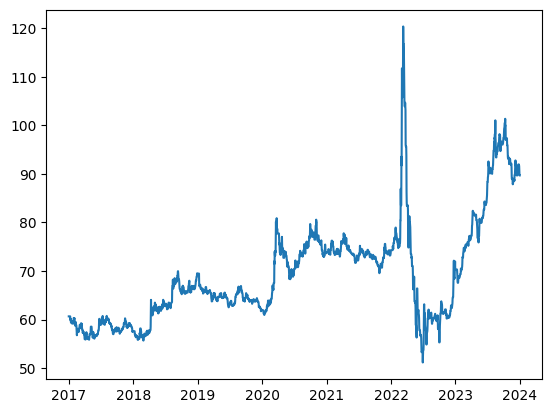

In [423]:
plt.plot(merged_df_new['date'], merged_df_new['exchange_rate'])

In [209]:
display(merged_df_new.tail())

,date,item_id,qnty,promo_typeCode,price_change_units,price_change_percent,day_of_week,day_of_sale,month_of_sale,season_of_sale,avg_sales_last_7_days,avg_sales_last_30_days,is_weekend,exchange_rate
147282,2023-12-31,100614,5.0,0.0,0.0,0.000000,6,31,12,1,5.714286,4.133333,True,89.6883
147283,2023-12-31,100140,4.0,6.0,60.0,8.001067,6,31,12,1,4.571429,2.733333,True,89.6883
147284,2023-12-31,100650,11.0,5.0,30.0,27.297543,6,31,12,1,17.000000,7.166667,True,89.6883
147285,2023-12-31,100182,1.0,0.0,0.0,0.000000,6,31,12,1,2.142857,1.866667,True,89.6883
147286,2023-12-31,100604,26.0,0.0,0.0,0.000000,6,31,12,1,14.714286,9.566667,True,89.6883


Пробуем обучить модель на новых данных

In [210]:
# Определяем целевую переменную и признаки
target = 'qnty'
features = merged_df_new.drop(columns=[target, 'date']).columns

# Разделение данных на обучающую и тестовую выборки по дате
train_df = merged_df_new[merged_df_new['date'] < '2022-08-12']
test_df = merged_df_new[merged_df_new['date'] >= '2022-08-12']

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

In [211]:
# Определение категориальных признаков
categorical_features = ['item_id', 'promo_typeCode', 'day_of_week', 'day_of_sale', 'month_of_sale', 'season_of_sale','is_weekend']
# Числовые признаки
numeric_features = ['price_change_units', 'price_change_percent', 'avg_sales_last_7_days', 'avg_sales_last_30_days']

# Преобразование признаков в строки для правильной работы CatBoostRegressor
X_train_cgr = X_train.copy()
X_test_cgr = X_test.copy()

for col in ['item_id', 'promo_typeCode', 'day_of_week','day_of_sale', 'month_of_sale', 'season_of_sale']:
    X_train_cgr[col] = X_train_cgr[col].astype(str)
    X_test_cgr[col] = X_test_cgr[col].astype(str)

# Создание пула данных для CatBoost
train_pool = Pool(X_train_cgr, y_train, cat_features=categorical_features)
test_pool = Pool(X_test_cgr, y_test, cat_features=categorical_features)

# Создание модели
model = CatBoostRegressor(
    iterations=3000,
    learning_rate=0.1,
    depth=10,
    loss_function='MAE',
    eval_metric='MAE',
    random_seed=42,
    l2_leaf_reg=3,
    bootstrap_type='Bernoulli',
    subsample=0.8,
    cat_features=categorical_features,
    one_hot_max_size=200,
    logging_level='Verbose',
    od_type='Iter',
    od_wait=500
)

# Обучение модели
model.fit(train_pool, eval_set=test_pool, verbose=100, early_stopping_rounds=300)

# Предсказание на тестовом наборе данных
y_pred = model.predict(test_pool)

# Оценка качества модели
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error: {rmse}')
print(f'MAE: {mae}')
print(f'R2: {r2:.4f}')

0:	learn: 6.8976578	test: 7.1135802	best: 7.1135802 (0)	total: 26.3ms	remaining: 1m 19s
100:	learn: 3.2927510	test: 3.0256643	best: 3.0243892 (97)	total: 1.93s	remaining: 55.5s
200:	learn: 3.1491983	test: 3.0045510	best: 3.0033437 (186)	total: 3.88s	remaining: 54.1s
300:	learn: 3.0221087	test: 3.0089482	best: 2.9969612 (244)	total: 5.82s	remaining: 52.2s
400:	learn: 2.9340934	test: 3.0182325	best: 2.9969612 (244)	total: 7.76s	remaining: 50.3s
500:	learn: 2.8502371	test: 3.0464320	best: 2.9969612 (244)	total: 9.72s	remaining: 48.5s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 2.996961202
bestIteration = 244

Shrink model to first 245 iterations.
Root Mean Squared Error: 10.56281346768857
MAE: 2.996962200931535
R2: 0.8859


Метрика стала хуже,отказываемся от этой идеи

#### Посмотрим на разделение по дате, возможно оно неравномерное и это мешает метрике

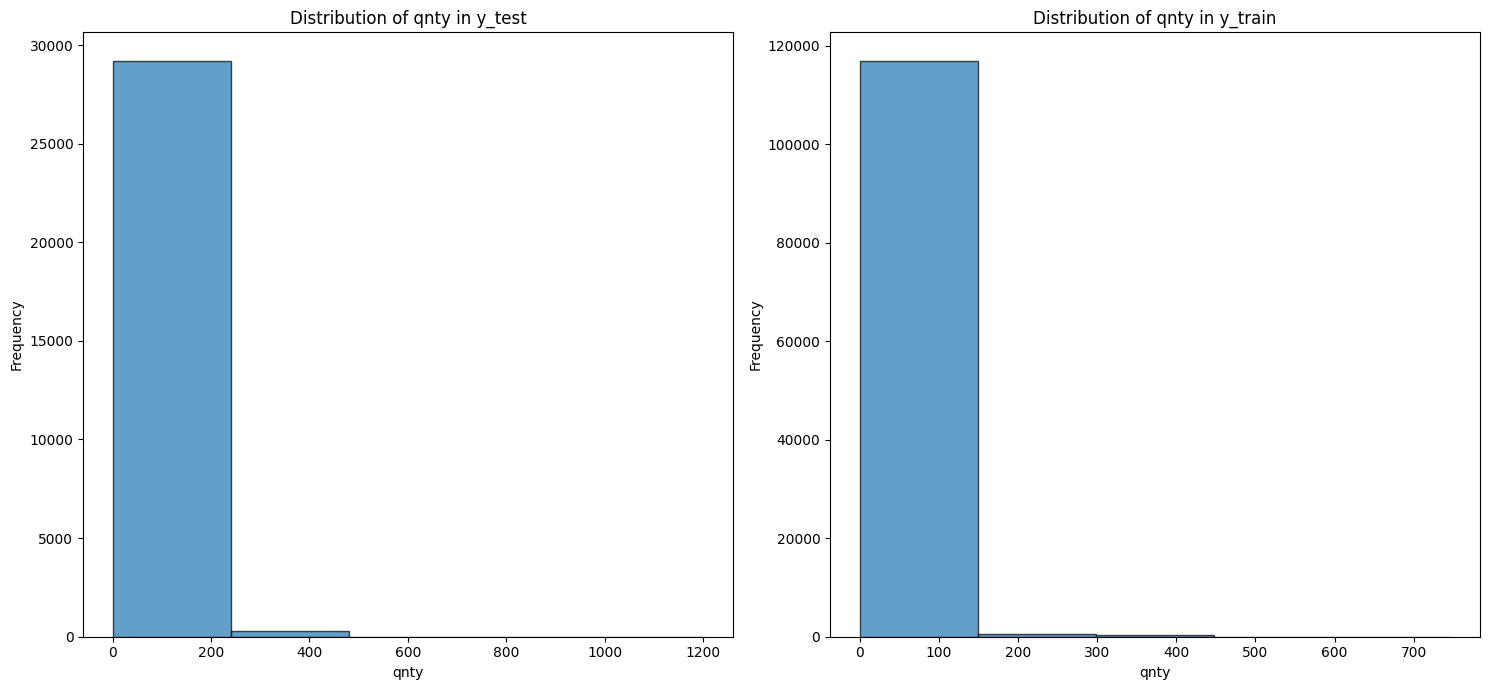

In [212]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

# Распределение значений qnty в y_test
ax[0].hist(y_test, bins=5, edgecolor='k', alpha=0.7)
ax[0].set_title('Distribution of qnty in y_test')
ax[0].set_xlabel('qnty')
ax[0].set_ylabel('Frequency')

# Распределение значений qnty в y_train
ax[1].hist(y_train, bins=5, edgecolor='k', alpha=0.7)
ax[1].set_title('Distribution of qnty in y_train')
ax[1].set_xlabel('qnty')
ax[1].set_ylabel('Frequency')

# Показать графики
plt.tight_layout()
plt.show()

Действительно, не совсем равномерное, попробуем изменить дату разделения

In [216]:
# Определяем целевую переменную и признаки
target = 'qnty'
features = merged_df.drop(columns=[target, 'date']).columns

# Разделение данных на обучающую и тестовую выборки по дате
train_df = merged_df[merged_df['date'] < '2022-12-31']
test_df = merged_df[merged_df['date'] >= '2022-12-31']

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

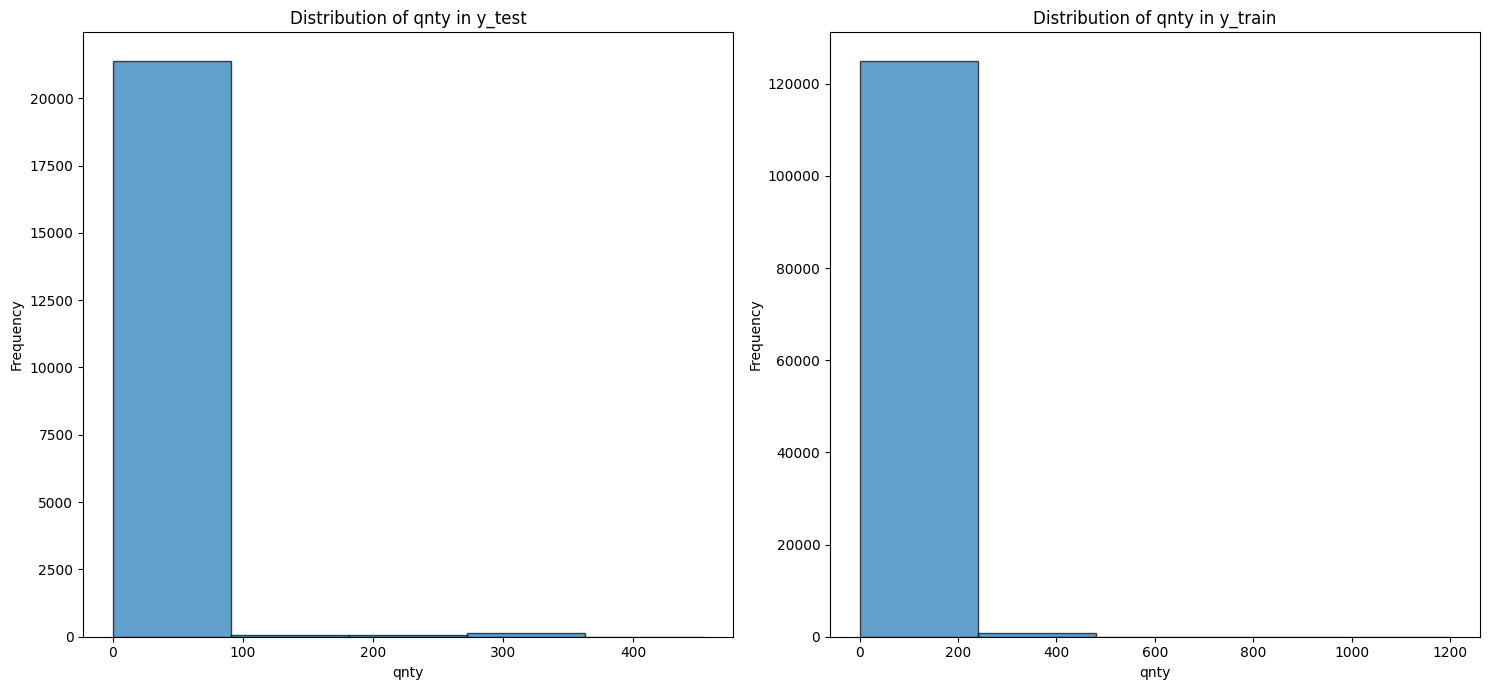

In [218]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

# Распределение значений qnty в y_test
ax[0].hist(y_test, bins=5, edgecolor='k', alpha=0.7)
ax[0].set_title('Distribution of qnty in y_test')
ax[0].set_xlabel('qnty')
ax[0].set_ylabel('Frequency')

# Распределение значений qnty в y_train
ax[1].hist(y_train, bins=5, edgecolor='k', alpha=0.7)
ax[1].set_title('Distribution of qnty in y_train')
ax[1].set_xlabel('qnty')
ax[1].set_ylabel('Frequency')

# Показать графики
plt.tight_layout()
plt.show()

Обучим модель на этих данных

In [217]:
# Определение категориальных признаков
categorical_features = ['item_id', 'promo_typeCode', 'day_of_week', 'day_of_sale', 'month_of_sale', 'season_of_sale','is_weekend']
# Числовые признаки
numeric_features = ['price_change_units', 'price_change_percent', 'avg_sales_last_7_days', 'avg_sales_last_30_days']

# Преобразование признаков в строки для правильной работы CatBoostRegressor
X_train_cgr = X_train.copy()
X_test_cgr = X_test.copy()

for col in ['item_id', 'promo_typeCode', 'day_of_week', 'day_of_sale', 'month_of_sale', 'season_of_sale']:
    X_train_cgr[col] = X_train_cgr[col].astype(str)
    X_test_cgr[col] = X_test_cgr[col].astype(str)

# Создание пула данных для CatBoost
train_pool = Pool(X_train_cgr, y_train, cat_features=categorical_features)
test_pool = Pool(X_test_cgr, y_test, cat_features=categorical_features)

# Создание модели
model = CatBoostRegressor(
    iterations=3000,
    learning_rate=0.1,
    depth=10,
    loss_function='MAE',
    eval_metric='MAE',
    random_seed=42,
    l2_leaf_reg=3,
    bootstrap_type='Bernoulli',
    subsample=0.8,
    cat_features=categorical_features,
    one_hot_max_size=200,
    logging_level='Verbose',
    od_type='Iter',
    od_wait=500
)

# Обучение модели
model.fit(train_pool, eval_set=test_pool, verbose=100, early_stopping_rounds=300)

# Предсказание на тестовом наборе данных
y_pred = model.predict(test_pool)

# Оценка качества модели
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error: {rmse}')
print(f'MAE: {mae}')
print(f'R2: {r2:.4f}')

0:	learn: 6.9546582	test: 6.6795744	best: 6.6795744 (0)	total: 27.3ms	remaining: 1m 21s
100:	learn: 3.3198273	test: 2.7679519	best: 2.7679519 (100)	total: 1.89s	remaining: 54.4s
200:	learn: 3.1935659	test: 2.7344851	best: 2.7308362 (173)	total: 3.78s	remaining: 52.7s
300:	learn: 3.0709715	test: 2.7378178	best: 2.7290018 (226)	total: 5.64s	remaining: 50.6s
400:	learn: 2.9774039	test: 2.7375295	best: 2.7290018 (226)	total: 7.58s	remaining: 49.1s
500:	learn: 2.9117568	test: 2.7457729	best: 2.7290018 (226)	total: 9.51s	remaining: 47.4s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 2.72900177
bestIteration = 226

Shrink model to first 227 iterations.
Root Mean Squared Error: 6.426621098685848
MAE: 2.729002769708777
R2: 0.9519


Дело и вправду в разделяющей дате, но так как в дальнейшем мы будем обучать модель на всех данных и делать предсказание для будущего, этот гиперпараметр не релевантен.

#### Попробуем посмотреть на выбросы.
По распределнию данных в тесте и трейне они есть, попробуем убрать их и построить модель снова:

In [417]:
#Разобьем данные qnty по диапозонам и посмотрим сколько сделок было совершенно в пределах этого диапозона
# Пример столбца для бинирования
column_to_bin = 'qnty'

# Создание бинов
merged_df['bins'] = pd.cut(merged_df[column_to_bin], bins=10)

# Подсчет количества сделок в каждом бине
deal_counts = merged_df['bins'].value_counts().sort_index()

merged_df=merged_df.drop('bins',axis=1)

# Вывод результатов
print(deal_counts)

bins
(-1.201, 120.1]     145904
(120.1, 240.2]         466
(240.2, 360.3]         837
(360.3, 480.4]          73
(480.4, 600.5]           4
(600.5, 720.6]           1
(720.6, 840.7]           1
(840.7, 960.8]           0
(960.8, 1080.9]          0
(1080.9, 1201.0]         1
Name: count, dtype: int64


Попробуем убрать редкие значения и снова обучить модель:

In [418]:

# Удаление значений в столбце 'qnty', превышающих 480.240.2
threshold = 240.2
merged_df_new_cleaned = merged_df[merged_df['qnty'] <= threshold]

# Проверка размеров до и после удаления выбросов
print(f"Размер merged_df_new до удаления значений: {merged_df.shape}")
print(f"Размер merged_df_new после удаления значений: {merged_df_new_cleaned.shape}")


Размер merged_df_new до удаления значений: (147287, 13)
Размер merged_df_new после удаления значений: (146370, 13)


In [419]:
# Определяем целевую переменную и признаки
target = 'qnty'
features = merged_df_new_cleaned.drop(columns=[target, 'date']).columns

# Разделение данных на обучающую и тестовую выборки по дате
train_df = merged_df_new_cleaned[merged_df_new_cleaned['date'] < '2022-12-31']
test_df = merged_df_new_cleaned[merged_df_new_cleaned['date'] >= '2022-12-31']

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

In [244]:
merged_df_new_cleaned

,date,item_id,qnty,promo_typeCode,price_change_units,price_change_percent,day_of_week,day_of_sale,month_of_sale,season_of_sale,avg_sales_last_7_days,avg_sales_last_30_days,is_weekend
0,2017-01-01,100001,7.0,0.0,0.0,0.000000,6,1,1,1,7.000000,7.000000,True
1,2017-01-01,100003,2.0,0.0,0.0,0.000000,6,1,1,1,2.000000,2.000000,True
2,2017-01-01,100006,13.0,0.0,0.0,0.000000,6,1,1,1,13.000000,13.000000,True
3,2017-01-01,100010,5.0,0.0,0.0,0.000000,6,1,1,1,5.000000,5.000000,True
4,2017-01-01,100035,53.0,0.0,0.0,0.000000,6,1,1,1,53.000000,53.000000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
147282,2023-12-31,100614,5.0,0.0,0.0,0.000000,6,31,12,1,5.714286,4.133333,True
147283,2023-12-31,100140,4.0,6.0,60.0,8.001067,6,31,12,1,4.571429,2.733333,True
147284,2023-12-31,100650,11.0,5.0,30.0,27.297543,6,31,12,1,17.000000,7.166667,True
147285,2023-12-31,100182,1.0,0.0,0.0,0.000000,6,31,12,1,2.142857,1.866667,True


In [245]:
# Определение категориальных признаков
categorical_features = ['item_id', 'promo_typeCode', 'day_of_week', 'day_of_sale', 'month_of_sale', 'season_of_sale','is_weekend']
# Числовые признаки
numeric_features = ['price_change_units', 'price_change_percent', 'avg_sales_last_7_days', 'avg_sales_last_30_days']

# Преобразование признаков в строки для правильной работы CatBoostRegressor
X_train_cgr = X_train.copy()
X_test_cgr = X_test.copy()

for col in ['item_id', 'promo_typeCode', 'day_of_week', 'day_of_sale', 'month_of_sale', 'season_of_sale']:
    X_train_cgr[col] = X_train_cgr[col].astype(str)
    X_test_cgr[col] = X_test_cgr[col].astype(str)

# Создание пула данных для CatBoost
train_pool = Pool(X_train_cgr, y_train, cat_features=categorical_features)
test_pool = Pool(X_test_cgr, y_test, cat_features=categorical_features)

# Создание модели
model = CatBoostRegressor(
    iterations=3000,
    learning_rate=0.1,
    depth=10,
    loss_function='MAE',
    eval_metric='MAE',
    random_seed=42,
    l2_leaf_reg=3,
    bootstrap_type='Bernoulli',
    subsample=0.8,
    cat_features=categorical_features,
    one_hot_max_size=200,
    logging_level='Verbose',
    od_type='Iter',
    od_wait=500
)

# Обучение модели
model.fit(train_pool, eval_set=test_pool, verbose=100, early_stopping_rounds=300)

# Предсказание на тестовом наборе данных
y_pred = model.predict(test_pool)

# Оценка качества модели
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error: {rmse}')
print(f'MAE: {mae}')
print(f'R2: {r2:.4f}')

0:	learn: 5.2833150	test: 4.1578135	best: 4.1578135 (0)	total: 23.3ms	remaining: 1m 9s
100:	learn: 3.0968311	test: 2.5562820	best: 2.5562179 (99)	total: 1.9s	remaining: 54.6s
200:	learn: 2.9552703	test: 2.5102921	best: 2.5053462 (168)	total: 3.8s	remaining: 52.9s
300:	learn: 2.8487293	test: 2.5089999	best: 2.5053462 (168)	total: 5.75s	remaining: 51.6s
400:	learn: 2.7588994	test: 2.5127362	best: 2.5053462 (168)	total: 7.64s	remaining: 49.5s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 2.505346231
bestIteration = 168

Shrink model to first 169 iterations.
Root Mean Squared Error: 5.609800689795288
MAE: 2.5053472248569855
R2: 0.7465


На первый взгляд, метрики значительно улучшились, но в реальной задаче у нас будут тестовые данные, в том числе с выбросами. Поэтому будет правильнее тестировать на неочищенных от них данных.

In [420]:
# Определяем целевую переменную и признаки
target = 'qnty'
features = merged_df_new_cleaned.drop(columns=[target, 'date']).columns

# Разделение данных на обучающую и тестовую выборки по дате
train_df = merged_df_new_cleaned[merged_df_new_cleaned['date'] < '2022-12-31']
test_df = merged_df[merged_df['date'] >= '2022-12-31']

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

# Определение категориальных признаков
categorical_features = ['item_id', 'promo_typeCode', 'day_of_week', 'day_of_sale', 'month_of_sale', 'season_of_sale','is_weekend']
# Числовые признаки
numeric_features = ['price_change_units', 'price_change_percent', 'avg_sales_last_7_days', 'avg_sales_last_30_days']

# Преобразование признаков в строки для правильной работы CatBoostRegressor
X_train_cgr = X_train.copy()
X_test_cgr = X_test.copy()

for col in ['item_id', 'promo_typeCode', 'day_of_week', 'day_of_sale', 'month_of_sale', 'season_of_sale']:
    X_train_cgr[col] = X_train_cgr[col].astype(str)
    X_test_cgr[col] = X_test_cgr[col].astype(str)

# Создание пула данных для CatBoost
train_pool = Pool(X_train_cgr, y_train, cat_features=categorical_features)
test_pool = Pool(X_test_cgr, y_test, cat_features=categorical_features)

# Создание модели
model = CatBoostRegressor(
    iterations=3000,
    learning_rate=0.1,
    depth=10,
    loss_function='MAE',
    eval_metric='MAE',
    random_seed=42,
    l2_leaf_reg=3,
    bootstrap_type='Bernoulli',
    subsample=0.8,
    cat_features=categorical_features,
    one_hot_max_size=200,
    logging_level='Verbose',
    od_type='Iter',
    od_wait=500
)

# Обучение модели
model.fit(train_pool, eval_set=test_pool, verbose=100, early_stopping_rounds=300)

# Предсказание на тестовом наборе данных
y_pred = model.predict(test_pool)

# Оценка качества модели
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error: {rmse}')
print(f'MAE: {mae}')
print(f'R2: {r2:.4f}')

0:	learn: 5.2833150	test: 6.6967950	best: 6.6967950 (0)	total: 23.7ms	remaining: 1m 11s
100:	learn: 3.0968311	test: 3.6439371	best: 3.6438734 (99)	total: 2.08s	remaining: 59.6s
200:	learn: 2.9552703	test: 3.2832596	best: 3.2832596 (200)	total: 4.15s	remaining: 57.8s
300:	learn: 2.8487293	test: 3.2466029	best: 3.2465893 (299)	total: 6.24s	remaining: 55.9s
400:	learn: 2.7588994	test: 3.2239522	best: 3.2182204 (358)	total: 8.32s	remaining: 54s
500:	learn: 2.6856039	test: 3.2115462	best: 3.2107761 (498)	total: 10.4s	remaining: 51.7s
600:	learn: 2.6269438	test: 3.2228072	best: 3.2107761 (498)	total: 12.4s	remaining: 49.3s
700:	learn: 2.5769336	test: 3.2214311	best: 3.2107761 (498)	total: 14.4s	remaining: 47.1s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 3.210776068
bestIteration = 498

Shrink model to first 499 iterations.
Root Mean Squared Error: 9.96819952902973
MAE: 3.2107770680826375
R2: 0.8842


И тут мы видим, что метрика не улучишлась, а наоборот ухудшилась. Отказываемся от этой идеи и пробуем другие способы

#### Optuna
##### Пробуем улучшить метрику,путем подбора гиперпараметров с помощью фреймворка Optuna:

In [290]:
# Определяем целевую переменную и признаки
target = 'qnty'
features = merged_df.drop(columns=[target, 'date']).columns

# Разделение данных на обучающую и тестовую выборки по дате
train_df = merged_df[merged_df['date'] < '2022-12-31']
test_df = merged_df[merged_df['date'] >= '2022-12-31']

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

In [291]:
# Определение категориальных признаков
categorical_features = ['item_id', 'promo_typeCode', 'day_of_week', 'day_of_sale', 'month_of_sale', 'season_of_sale','is_weekend']
# Числовые признаки
numeric_features = ['price_change_units', 'price_change_percent', 'avg_sales_last_7_days', 'avg_sales_last_30_days']

# Преобразование признаков в строки для правильной работы CatBoostRegressor
X_train_cgr = X_train.copy()
X_test_cgr = X_test.copy()

for col in ['item_id', 'promo_typeCode', 'day_of_week','day_of_sale', 'month_of_sale', 'season_of_sale']:
    X_train_cgr[col] = X_train_cgr[col].astype(str)
    X_test_cgr[col] = X_test_cgr[col].astype(str)

In [292]:
import optuna
from optuna.integration import CatBoostPruningCallback

import warnings
from optuna.exceptions import ExperimentalWarning

# Подавление конкретного предупреждения
warnings.filterwarnings("ignore", category=ExperimentalWarning)


# Загрузка данных (ваши данные)
# Создание столбца 'date' из sales_df как datetime и т.д.
# (Ваши предыдущие шаги предобработки данных)

# Определение пространства гиперпараметров и функции для оптимизации
def objective(trial):
    params = {
        'iterations': trial.suggest_categorical('iterations', [1000, 3000, 5000]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 9, step=2),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bernoulli', 'MVS']),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'one_hot_max_size': trial.suggest_int('one_hot_max_size', 150, 400, step=5)
    }
    
    
    # Создание модели
    model = CatBoostRegressor(
        **params,
        loss_function='MAE',
        eval_metric='MAE',
        random_seed=42,
        cat_features=categorical_features,
        logging_level='Silent'
    )

    # Использование PruningCallback для обрезки
    pruning_callback = CatBoostPruningCallback(trial, 'MAE')
    
    # Обучение модели
    model.fit(X_train_cgr, y_train, eval_set=(X_test_cgr, y_test), early_stopping_rounds=100, verbose=False, callbacks=[pruning_callback])
    
    # Предсказание и оценка
    y_pred = model.predict(X_test_cgr)
    mae = mean_absolute_error(y_test, y_pred)
    return mae

# Создание объекта исследования с использованием MedianPruner
study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=500, n_jobs=-1)

# Лучшие гиперпараметры
best_params = study.best_params
print("Best hyperparameters found by Optuna:")
print(best_params)

[I 2024-07-29 01:48:06,697] A new study created in memory with name: no-name-2cf74b84-fb1b-4a8b-b908-890be5f51960
[I 2024-07-29 01:49:01,635] Trial 6 finished with value: 2.7036770936633574 and parameters: {'iterations': 3000, 'learning_rate': 0.08143219025638039, 'depth': 8, 'l2_leaf_reg': 1, 'bootstrap_type': 'Bernoulli', 'subsample': 0.9209910962187238, 'one_hot_max_size': 265}. Best is trial 6 with value: 2.7036770936633574.
[I 2024-07-29 01:49:10,935] Trial 21 finished with value: 2.755173056365474 and parameters: {'iterations': 1000, 'learning_rate': 0.14240420479794538, 'depth': 5, 'l2_leaf_reg': 3, 'bootstrap_type': 'Bernoulli', 'subsample': 0.8727187726680086, 'one_hot_max_size': 215}. Best is trial 6 with value: 2.7036770936633574.
[I 2024-07-29 01:49:13,970] Trial 17 finished with value: 2.755663677987779 and parameters: {'iterations': 1000, 'learning_rate': 0.13428333610767434, 'depth': 6, 'l2_leaf_reg': 1, 'bootstrap_type': 'Bernoulli', 'subsample': 0.8770784216233738, 'on

Best hyperparameters found by Optuna:
{'iterations': 1000, 'learning_rate': 0.13268671230043036, 'depth': 8, 'l2_leaf_reg': 5, 'bootstrap_type': 'MVS', 'subsample': 0.6923433825402382, 'one_hot_max_size': 395}


In [293]:
# Лучшая модель
best_model = CatBoostRegressor(
    **best_params,
    loss_function='MAE',
    eval_metric='MAE',
    random_seed=42,
    cat_features=categorical_features,
    logging_level='Silent'
)

# Обучение модели
best_model.fit(X_train_cgr, y_train, eval_set=(X_test_cgr, y_test), early_stopping_rounds=300, verbose=100)

# Предсказание на тестовом наборе данных
y_pred = best_model.predict(X_test_cgr)

# Оценка качества модели
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Оценка качества модели
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Root Mean Squared Error: {rmse}')
print(f'MAE: {mae}')

Root Mean Squared Error: 6.376543112953771
MAE: 2.68879826698273


Метрика возросла, оставляем эти гиперпараметры

Визиализируем предсказания по отношению к реальным данным:

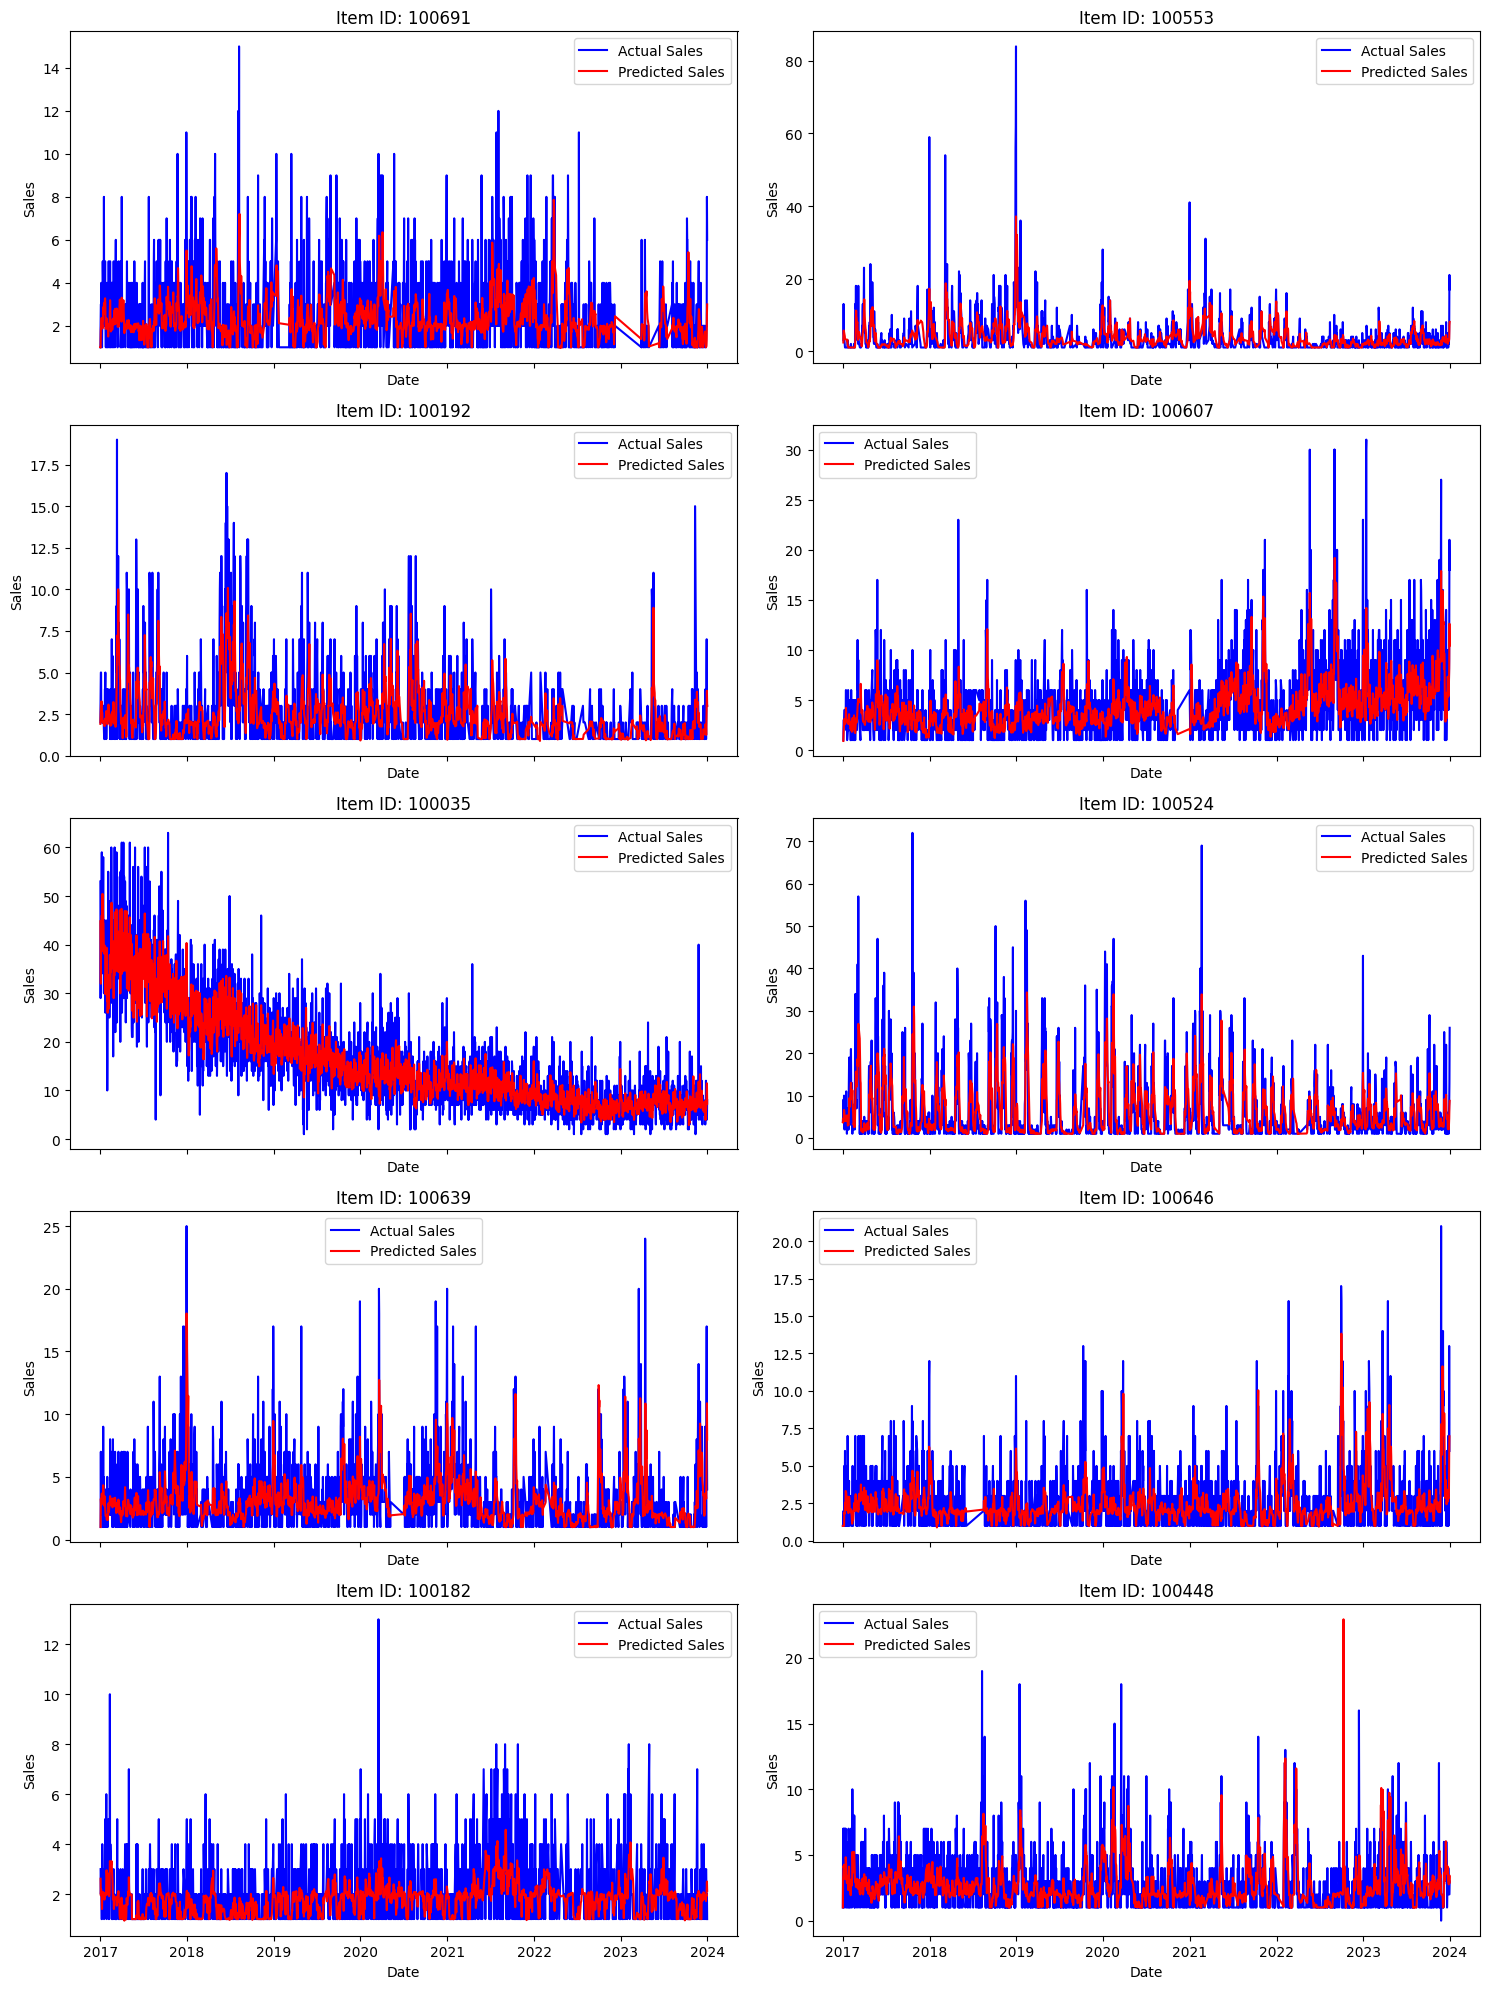

In [294]:
temp_df=merged_df.copy()

for col in ['item_id', 'promo_typeCode', 'day_of_week', 'day_of_sale', 'month_of_sale', 'season_of_sale']:
    temp_df[col] = temp_df[col].astype(str)
    temp_df[col] = temp_df[col].astype(str)

# Выбираем 10 случайных товаров
random_items = temp_df['item_id'].sample(n=11, random_state=42).unique()

# Создаем фигуру для графиков
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20), sharex=True)
axes = axes.flatten()

for i, item_id in enumerate(random_items):
    # Фильтрация данных для конкретного товара
    item_data = temp_df[temp_df['item_id'] == item_id]
    
    # Реальные значения продаж
    actual_sales = item_data['qnty']
    
    # Предсказанные значения продаж
    predicted_sales = model.predict(item_data[features])
    
    # Построение графика
    axes[i].plot(item_data['date'], actual_sales, label='Actual Sales', color='blue')
    axes[i].plot(item_data['date'], predicted_sales, label='Predicted Sales', color='red', linestyle='-')
    axes[i].set_title(f'Item ID: {item_id}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Sales')
    axes[i].legend()

plt.tight_layout()
plt.show()

Дополнительные метрики:

In [295]:
# Функция для вычисления MAPE без учета нулевых значений в y_test
def mean_absolute_percentage_error_no_zeros(y_true, y_pred):
    non_zero_idx = y_true != 0
    return np.mean(np.abs((y_true[non_zero_idx] - y_pred[non_zero_idx]) / y_true[non_zero_idx])) * 100

mape_no_zeros = mean_absolute_percentage_error_no_zeros(y_test.values, y_pred)
print(f'MAPE without zeros: {mape_no_zeros:.3f}%')

MAPE without zeros: 60.724%


In [296]:
max_qnty = y_test.max()
mean_qnty = y_test.mean()

print(f'Max qnty: {max_qnty}')
print(f'Mean qnty: {mean_qnty}')
print(f'RMSE as percentage of max qnty: {(rmse / max_qnty) * 100:.2f}%')
print(f'RMSE as percentage of mean qnty: {(rmse / mean_qnty) * 100:.2f}%')

Max qnty: 454.0
Mean qnty: 8.470170633636826
RMSE as percentage of max qnty: 1.40%
RMSE as percentage of mean qnty: 75.28%


In [297]:
# Прогнозы базовой модели (среднее значение)
mean_qnty_pred = np.full_like(y_test, y_test.mean())
rmse_baseline = root_mean_squared_error(y_test, mean_qnty_pred)

print(f'Baseline RMSE (mean model): {rmse_baseline}')
print(f'Improvement over baseline: {(rmse_baseline - rmse) / rmse_baseline * 100:.2f}%')

Baseline RMSE (mean model): 29.294027777599407
Improvement over baseline: 78.23%


Создадим датафрейм с предсказаниями prediction_data. В prediction_data будут дни января и id предметов из числа item_id, проданных в декабре.

In [404]:
# Шаг 1: Извлекаем список item_id из продаж в декабре 2023 года
december_sales = merged_df[(merged_df['date'] >= '2023-12-01') & (merged_df['date'] <= '2023-12-31')]
december_item_ids = december_sales['item_id'].unique()

# Шаг 2: Создаем DataFrame с датами на январь 2024 года и всеми item_id из декабрьских продаж
start_date = datetime(2024, 1, 1)
end_date = datetime(2024, 1, 31)
date_range = pd.date_range(start=start_date, end=end_date)

prediction_data = pd.DataFrame([(date, item_id) for date in date_range for item_id in december_item_ids], columns=['date', 'item_id'])

In [405]:
prediction_data

,date,item_id
0,2024-01-01,100545
1,2024-01-01,100645
2,2024-01-01,100683
3,2024-01-01,100612
4,2024-01-01,100165
...,...,...
3002,2024-01-31,100474
3003,2024-01-31,100386
3004,2024-01-31,100375
3005,2024-01-31,100046


В discounts_df были данные за январь 2024. Чтобы не упускать ценные признаки, объединим его с prediction_data по тому же принципу, что и ранее объединяли с sales_df.

In [406]:
prediction_data_merged = pd.merge(prediction_data, expanded_discounts_df, on=['item_id', 'date'], how='left')

In [407]:
prediction_data_merged

,date,item_id,promo_typeCode,sale_price_before_promo,sale_price_time_promo,date_start,date_end
0,2024-01-01,100545,NaN,NaN,NaN,NaT,NaT
1,2024-01-01,100645,5.0,154.9,99.9,2023-12-20,2024-01-10
2,2024-01-01,100683,NaN,NaN,NaN,NaT,NaT
3,2024-01-01,100612,NaN,NaN,NaN,NaT,NaT
4,2024-01-01,100165,5.0,63.9,54.9,2023-12-26,2024-01-10
...,...,...,...,...,...,...,...
3002,2024-01-31,100474,5.0,69.9,49.9,2024-01-30,2024-02-14
3003,2024-01-31,100386,NaN,NaN,NaN,NaT,NaT
3004,2024-01-31,100375,NaN,NaN,NaN,NaT,NaT
3005,2024-01-31,100046,NaN,NaN,NaN,NaT,NaT


Добавим все те же признаки,что добавляли в merged_df:

In [408]:
# Добавление признаков изменения цены в единицах и процентах
prediction_data_merged['price_change_units'] = prediction_data_merged['sale_price_before_promo'] - prediction_data_merged['sale_price_time_promo']
prediction_data_merged['price_change_percent'] = (prediction_data_merged['price_change_units'] / prediction_data_merged['sale_price_before_promo']) * 100

# Добавление признака дня недели
prediction_data_merged['day_of_week'] = prediction_data_merged['date'].dt.dayofweek

prediction_data_merged=prediction_data_merged.drop(['date_start','date_end','sale_price_before_promo','sale_price_time_promo'],axis=1)

# Заполнение пропусков в promo_typeCode нулями
prediction_data_merged.fillna(0, inplace=True)

# Добавление признаков день продажи, месяц продажи, сезон продажи
prediction_data_merged['day_of_sale'] = prediction_data_merged['date'].dt.day
prediction_data_merged['month_of_sale'] = prediction_data_merged['date'].dt.month
prediction_data_merged['season_of_sale'] = prediction_data_merged['date'].dt.month % 12 // 3 + 1  # Сезоны: 1 - зима, 2 - весна, 3 - лето, 4 - осень

# Флаги выходных и праздничных дней
prediction_data_merged['is_weekend'] = prediction_data_merged['date'].dt.dayofweek >= 5

In [409]:
prediction_data_merged

,date,item_id,promo_typeCode,price_change_units,price_change_percent,day_of_week,day_of_sale,month_of_sale,season_of_sale,is_weekend
0,2024-01-01,100545,0.0,0.0,0.000000,0,1,1,1,False
1,2024-01-01,100645,5.0,55.0,35.506779,0,1,1,1,False
2,2024-01-01,100683,0.0,0.0,0.000000,0,1,1,1,False
3,2024-01-01,100612,0.0,0.0,0.000000,0,1,1,1,False
4,2024-01-01,100165,5.0,9.0,14.084507,0,1,1,1,False
...,...,...,...,...,...,...,...,...,...,...
3002,2024-01-31,100474,5.0,20.0,28.612303,2,31,1,1,False
3003,2024-01-31,100386,0.0,0.0,0.000000,2,31,1,1,False
3004,2024-01-31,100375,0.0,0.0,0.000000,2,31,1,1,False
3005,2024-01-31,100046,0.0,0.0,0.000000,2,31,1,1,False


In [410]:
merged_df['date'].max()

Timestamp('2023-12-31 00:00:00')

Строим модель предсказаний:

In [298]:
# Определение категориальных признаков
categorical_features = ['item_id', 'promo_typeCode', 'day_of_week', 'day_of_sale', 'month_of_sale', 'season_of_sale','is_weekend']
# Числовые признаки
numeric_features = ['price_change_units', 'price_change_percent', 'avg_sales_last_7_days', 'avg_sales_last_30_days']

In [299]:
# Определение целевой переменной и признаков
target = 'qnty'
features = merged_df.drop(columns=[target, 'date']).columns

# Шаг 1: Переобучение модели на всех данных до 31 декабря 2023 года
train_data = merged_df
X_train_all = train_data[features]
y_train_all = train_data[target]

# Преобразование категориальных признаков в строки для CatBoostRegressor
for col in ['item_id', 'promo_typeCode', 'day_of_week', 'day_of_sale', 'month_of_sale', 'season_of_sale']:
    X_train_all[col] = X_train_all[col].astype(str)

# Создание и обучение модели с лучшими параметрами
best_model = CatBoostRegressor(
    **best_params,
    loss_function='MAE',
    eval_metric='MAE',
    random_seed=42,
    cat_features=categorical_features,
    logging_level='Silent'
)

best_model.fit(X_train_all, y_train_all, verbose=100)

# Шаг 2: Предсказание на новом датафрейме prediction_data_merged
# Преобразование категориальных признаков в строки для CatBoostRegressor
for col in ['item_id', 'promo_typeCode', 'day_of_week', 'day_of_sale', 'month_of_sale', 'season_of_sale']:
    prediction_data_merged[col] = prediction_data_merged[col].astype(str)

# Предсказания
predictions = best_model.predict(prediction_data_merged[features])

# Шаг 3: Сохранение результатов в CSV-файл с заданными условиями
prediction_data_merged['prediction'] = predictions
prediction_result = prediction_data_merged[['date', 'item_id', 'prediction']]



C:\Users\donru\AppData\Local\Temp\ipykernel_28556\3694753173.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_all[col] = X_train_all[col].astype(str)
C:\Users\donru\AppData\Local\Temp\ipykernel_28556\3694753173.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_all[col] = X_train_all[col].astype(str)
C:\Users\donru\AppData\Local\Temp\ipykernel_28556\3694753173.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

KeyError: "['avg_sales_last_7_days', 'avg_sales_last_30_days'] not in index"

Столкнулись с ошибкой: в sales_df нет признаков ['avg_sales_last_7_days', 'avg_sales_last_30_days']. Действительно, не зная количества продаж, нельзя посчитать скользящее среднее.

Чтобы проверить ценность этих признаков, были построены модели с ними и без них, и получились следующие результаты:

С признаками:

    Root Mean Squared Error: 6.376543112953771

    MAE: 2.68879826698273

Без признаков: 

    Root Mean Squared Error: 8.659097107007534
    
    MAE: 3.648154821853799
 
Признаки оказались действительно ценными, и не хотелось бы их упускать. Попробуем их сохранить всеми силами.

Создадим датафрейм historical_data с историческими данными до 31 декабря 2023 года. Объединим его с нашим prediction_data_merged для удобства.

Предскажем qnty для 1 января по старым данным, затем посчитаем avg_sales_last_7_days и avg_sales_last_30_days для 1 января.

На основе этих данных предскажем продажи для 2 января и посчитаем avg_sales_last_7_days и avg_sales_last_30_days для 2 января.

Пройдемся по всем дням января таким образом. Так мы не упустим ценные признаки и сделаем более точное предсказание.

In [341]:
# Используем данные из merged_df до 31 декабря 2023 года
historical_data = merged_df[merged_df['date'] <= '2023-12-31']
historical_data['item_id'] = historical_data['item_id'].astype(str)

In [347]:
history_prediction = pd.concat([historical_data, prediction_data_merged], ignore_index=True)

In [391]:
# Обновляем тип данных для категориальных признаков
for col in ['item_id', 'promo_typeCode', 'day_of_week', 'day_of_sale', 'month_of_sale', 'season_of_sale', 'is_weekend']:
    history_prediction[col] = history_prediction[col].astype(str)

# Шаг 2: Переобучение модели на всех данных до 31 декабря 2023 года
best_model = CatBoostRegressor(
    **best_params,
    loss_function='MAE',
    eval_metric='MAE',
    random_seed=42,
    cat_features=categorical_features,
    logging_level='Silent'
)

X_train_all = history_prediction[history_prediction['date'] <= '2023-12-31'][features]
y_train_all = history_prediction[history_prediction['date'] <= '2023-12-31'][target]

# Преобразование категориальных признаков в строки для CatBoostRegressor
for col in ['item_id', 'promo_typeCode', 'day_of_week', 'day_of_sale', 'month_of_sale', 'season_of_sale', 'is_weekend']:
    X_train_all[col] = X_train_all[col].astype(str)

best_model.fit(X_train_all, y_train_all, verbose=100)

# Шаг 3: Итеративное предсказание и обновление скользящих средних
date_range = pd.date_range(start=datetime(2024, 1, 1), end=datetime(2024, 1, 31))

# Сначала предсказание для 1 января 2024 года
first_day = date_range[0]
first_day_data = history_prediction[history_prediction['date'] == first_day].copy()
first_day_predictions = best_model.predict(first_day_data[features])
history_prediction.loc[history_prediction['date'] == first_day, 'qnty'] = first_day_predictions

# Обновление скользящих средних для 1 января 2024 года
history_prediction.loc[history_prediction['date'] == first_day, 'avg_sales_last_7_days'] = history_prediction.groupby('item_id')['qnty'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())[history_prediction['date'] == first_day]
history_prediction.loc[history_prediction['date'] == first_day, 'avg_sales_last_30_days'] = history_prediction.groupby('item_id')['qnty'].transform(lambda x: x.rolling(window=30, min_periods=1).mean())[history_prediction['date'] == first_day]

# Итеративное предсказание для остальных дней января 2024 года
for date in date_range[1:]:
    # Предсказание qnty для текущего дня
    daily_data = history_prediction[history_prediction['date'] == date].copy()
    daily_predictions = best_model.predict(daily_data[features])
    history_prediction.loc[history_prediction['date'] == date, 'qnty'] = daily_predictions
    
    # Обновление скользящих средних для следующего дня
    next_day = date + timedelta(days=1)
    if next_day <= date_range[-1]:
        history_prediction.loc[history_prediction['date'] == date, 'avg_sales_last_7_days'] = history_prediction.groupby('item_id')['qnty'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())[history_prediction['date'] == date]
        history_prediction.loc[history_prediction['date'] == date, 'avg_sales_last_30_days'] = history_prediction.groupby('item_id')['qnty'].transform(lambda x: x.rolling(window=30, min_periods=1).mean())[history_prediction['date'] == date]

In [392]:
history_prediction

,date,item_id,qnty,promo_typeCode,price_change_units,price_change_percent,day_of_week,day_of_sale,month_of_sale,season_of_sale,avg_sales_last_7_days,avg_sales_last_30_days,is_weekend
0,2017-01-01,100001,7.000000,0.0,0.0,0.000000,6,1,1,1,7.000000,7.000000,True
1,2017-01-02,100001,1.000000,0.0,0.0,0.000000,0,2,1,1,4.000000,4.000000,False
2,2017-01-03,100001,14.000000,0.0,0.0,0.000000,1,3,1,1,7.333333,7.333333,False
3,2017-01-04,100001,3.000000,0.0,0.0,0.000000,2,4,1,1,6.250000,6.250000,False
4,2017-01-05,100001,15.000000,0.0,0.0,0.000000,3,5,1,1,8.000000,8.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
150289,2024-01-31,100474,15.550807,5.0,20.0,28.612303,2,31,1,1,5.502714,3.423412,False
150290,2024-01-31,100386,1.904199,0.0,0.0,0.000000,2,31,1,1,2.011634,3.162180,False
150291,2024-01-31,100375,1.051141,0.0,0.0,0.000000,2,31,1,1,1.062323,1.105090,False
150292,2024-01-31,100046,1.022085,0.0,0.0,0.000000,2,31,1,1,1.128780,1.152633,False


Оставим данные только за январь 2024 года:

In [413]:
prediction_data_merged = history_prediction[history_prediction['date'] >= '2024-01-01'].copy()

In [399]:
prediction_data_merged

,date,item_id,qnty,promo_typeCode,price_change_units,price_change_percent,day_of_week,day_of_sale,month_of_sale,season_of_sale,avg_sales_last_7_days,avg_sales_last_30_days,is_weekend
147287,2024-01-01,100545,2.354125,0.0,0.0,0.000000,0,1,1,1,20.479161,7.511804,False
147288,2024-01-01,100645,15.207879,5.0,55.0,35.506779,0,1,1,1,53.315411,17.440263,False
147289,2024-01-01,100683,0.893295,0.0,0.0,0.000000,0,1,1,1,1.413328,1.529777,False
147290,2024-01-01,100612,5.592465,0.0,0.0,0.000000,0,1,1,1,7.513209,7.619749,False
147291,2024-01-01,100165,35.626186,5.0,9.0,14.084507,0,1,1,1,33.375169,19.620873,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
150289,2024-01-31,100474,15.550807,5.0,20.0,28.612303,2,31,1,1,5.502714,3.423412,False
150290,2024-01-31,100386,1.904199,0.0,0.0,0.000000,2,31,1,1,2.011634,3.162180,False
150291,2024-01-31,100375,1.051141,0.0,0.0,0.000000,2,31,1,1,1.062323,1.105090,False
150292,2024-01-31,100046,1.022085,0.0,0.0,0.000000,2,31,1,1,1.128780,1.152633,False


In [400]:
prediction_data_merged.rename(columns={'qnty': 'prediction'}, inplace=True)

In [401]:
prediction_data_merged

,date,item_id,prediction,promo_typeCode,price_change_units,price_change_percent,day_of_week,day_of_sale,month_of_sale,season_of_sale,avg_sales_last_7_days,avg_sales_last_30_days,is_weekend
147287,2024-01-01,100545,2.354125,0.0,0.0,0.000000,0,1,1,1,20.479161,7.511804,False
147288,2024-01-01,100645,15.207879,5.0,55.0,35.506779,0,1,1,1,53.315411,17.440263,False
147289,2024-01-01,100683,0.893295,0.0,0.0,0.000000,0,1,1,1,1.413328,1.529777,False
147290,2024-01-01,100612,5.592465,0.0,0.0,0.000000,0,1,1,1,7.513209,7.619749,False
147291,2024-01-01,100165,35.626186,5.0,9.0,14.084507,0,1,1,1,33.375169,19.620873,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
150289,2024-01-31,100474,15.550807,5.0,20.0,28.612303,2,31,1,1,5.502714,3.423412,False
150290,2024-01-31,100386,1.904199,0.0,0.0,0.000000,2,31,1,1,2.011634,3.162180,False
150291,2024-01-31,100375,1.051141,0.0,0.0,0.000000,2,31,1,1,1.062323,1.105090,False
150292,2024-01-31,100046,1.022085,0.0,0.0,0.000000,2,31,1,1,1.128780,1.152633,False


In [402]:
# Сохранение результатов в CSV-файл с заданными условиями
prediction_result = prediction_data_merged[['date', 'item_id', 'prediction']].copy()
prediction_result.to_csv('predictions.csv', sep=';', index=False)

print("Прогнозы успешно сохранены в файл predictions.csv")

Прогнозы успешно сохранены в файл predictions.csv


Построим графики предсказаний:

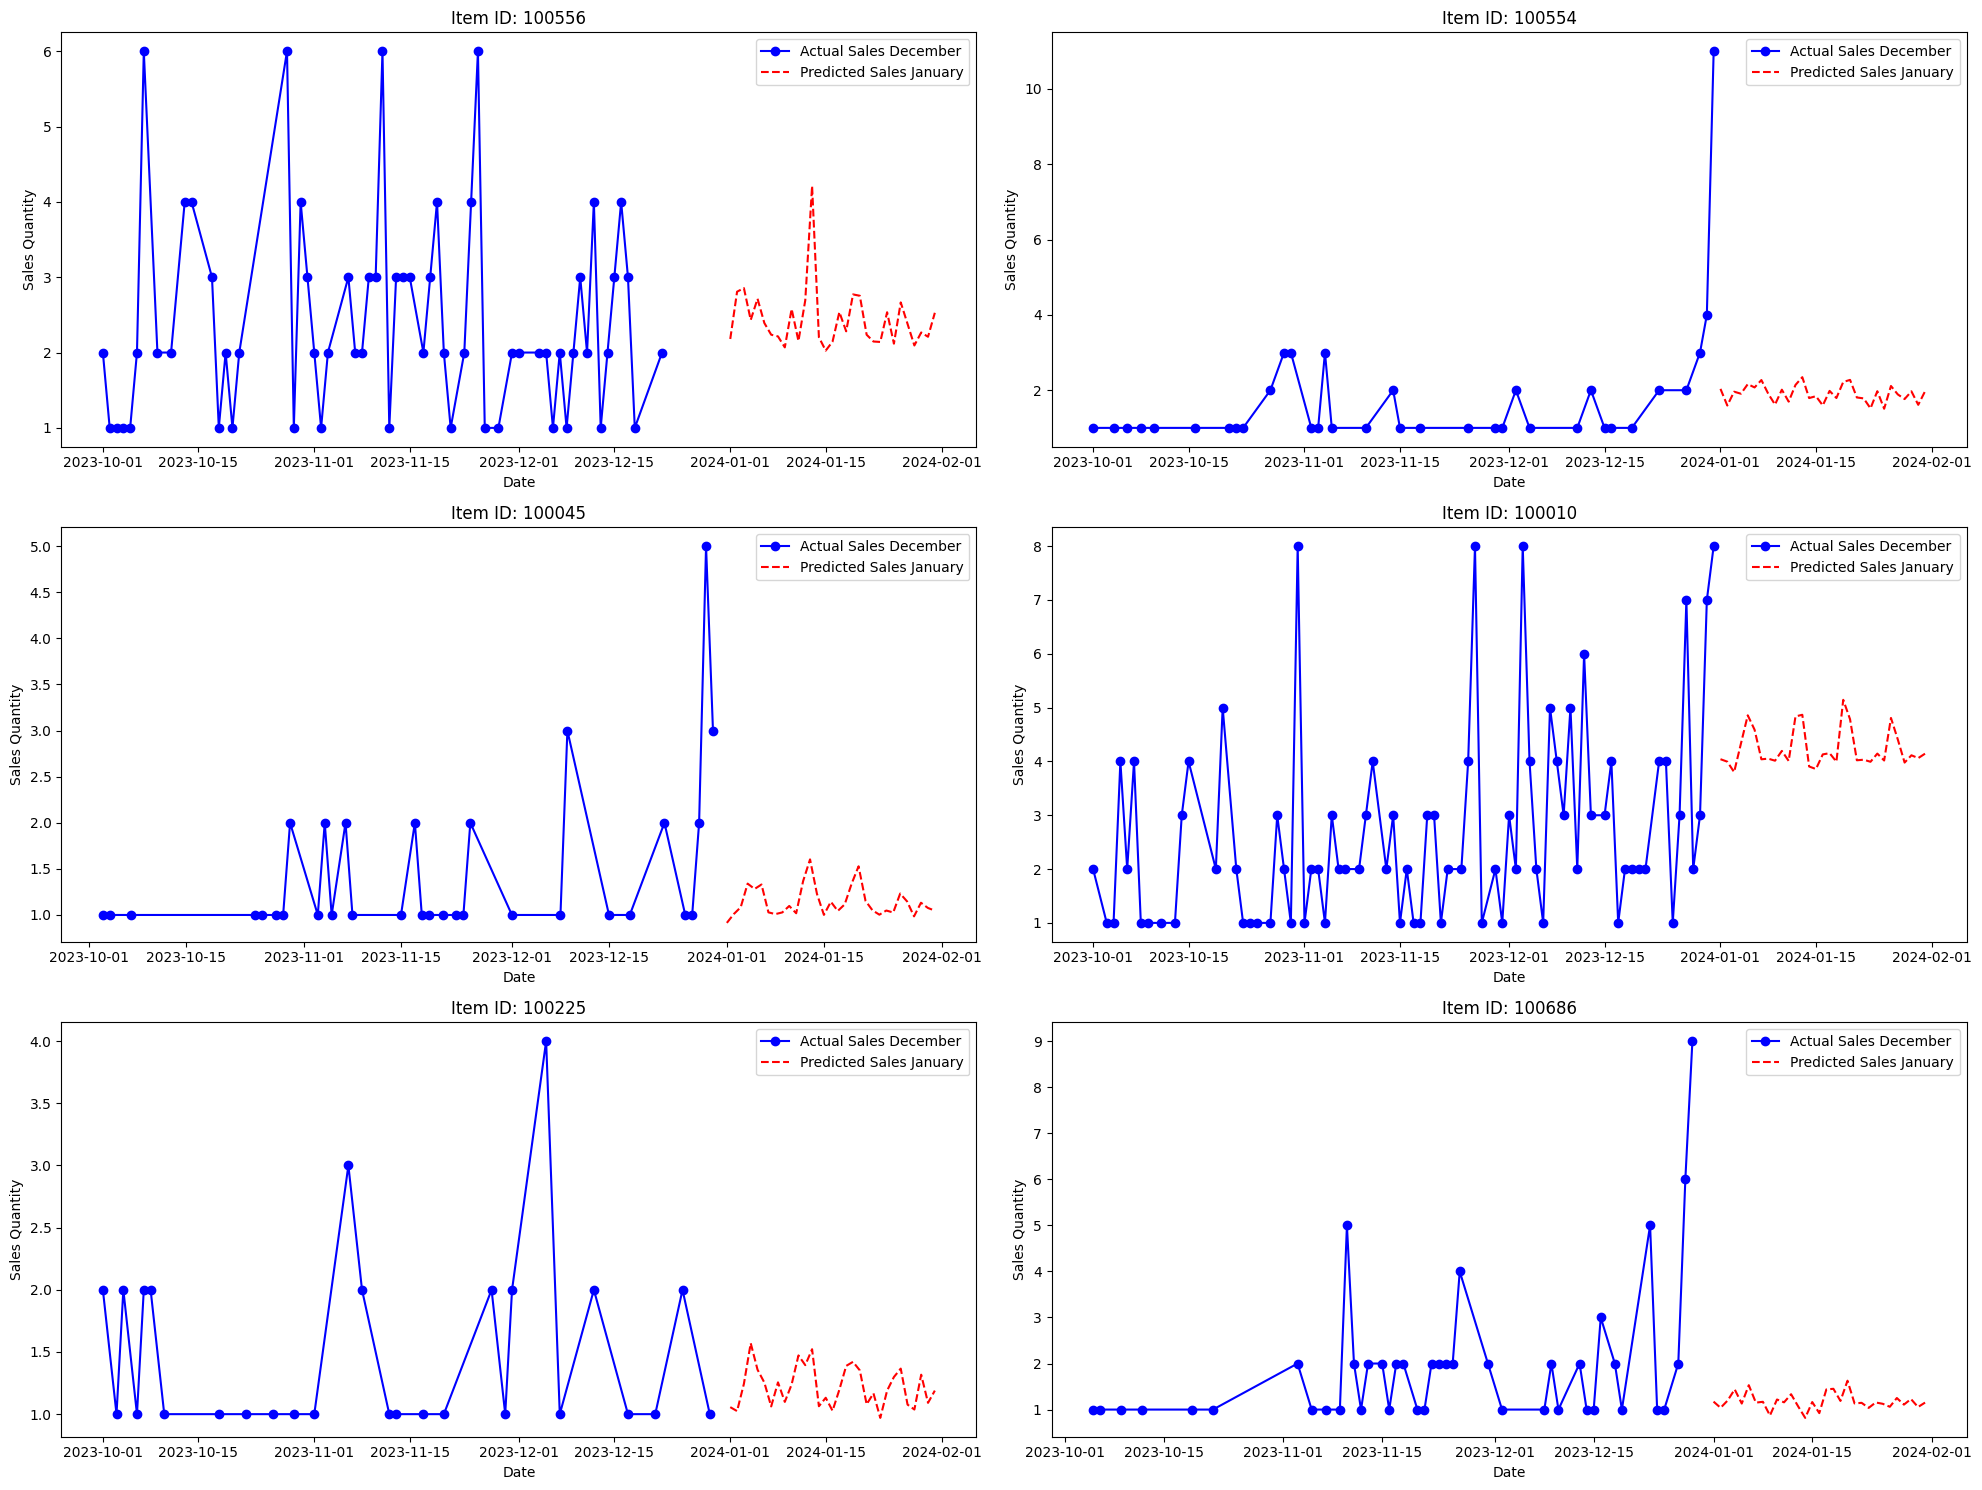

In [403]:
# Выбираем 6 случайных item_id
random_item_ids = random.sample(list(history_prediction['item_id'].unique()), 6)

# Настраиваем фигуру для графиков
plt.figure(figsize=(20, 15))

# Цикл по каждому item_id
for i, item_id in enumerate(random_item_ids, 1):
    plt.subplot(3, 2, i)
    
    # Данные для конкретного item_id
    item_data = history_prediction[history_prediction['item_id'] == item_id]
    
    # Реальные продажи в декабре 2023 года
    actual_sales_december = item_data[(item_data['date'] >= '2023-10-01') & (item_data['date'] <= '2023-12-31')]
    
    # Предсказанные продажи в январе 2024 года
    predicted_sales_january = item_data[(item_data['date'] >= '2024-01-01') & (item_data['date'] <= '2024-01-31')]
    
    # Графики реальных и предсказанных продаж
    plt.plot(actual_sales_december['date'], actual_sales_december['qnty'], label='Actual Sales December', color='blue', marker='o')
    plt.plot(predicted_sales_january['date'], predicted_sales_january['qnty'], label='Predicted Sales January', color='red', linestyle='--')
    
    # Настройка графика
    plt.title(f'Item ID: {item_id}')
    plt.xlabel('Date')
    plt.ylabel('Sales Quantity')
    plt.legend()

# Показать график
plt.tight_layout()
plt.show()